# Stratification Linked to Seasonality in Eddy Subduction in the Southern Ocean

Chen and Schofield, 2024

Subduction anomaly detection

### Import packages

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cmx
import matplotlib.ticker as mticker
import seaborn as sns

import scipy as sp
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

import xarray as xr
import numpy as np
import math
import itertools

import gsw as gsw

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime
from datetime import timedelta

import glob
import warnings

import pandas as pd
%matplotlib inline

import plotly.express as px

from tqdm import tqdm
import subprocess

### Import SOCCOM float data
* 2023-08-28 Data snapshot downloaded from https://library.ucsd.edu/dc/collection/bb0488375t
* Format: LIAR carbon algorithm, netCDF, low resolution 


In [2]:
floatspath = 'SOCCOM_GO-BGC_LoResQC_LIAR_28Aug2023_netcdf'

In [3]:
floats = pd.read_csv('{}/MBARI_float_list.txt'.format(floatspath),sep='\t')

In [4]:
floats

,MBARI ID,INST ID,WMO,float type,1st lon,1st lat,1st date,msg dir,NC template,Program,...,tf NO3,tf pH,tf Chl,tf OCR,max cycle msg file,max cycle file date,latest cycle msg file,latest cycle file date,max cycle proc,max cycle proc date
0,ss0001,1,4903026,SOLO,-122.512,36.762,02/05/2022 03:42,\\seaecho.shore.mbari.org\floats\SIO\ss0001\,1,GO-BGC,...,1,1,1,1,231.0,08/09/2023 08:02,231.0,08/09/2023 08:02,231.0,08/09/2023 06:05
1,ss0002,2,5906765,SOLO,-166.522,2.005,03/28/2022 17:31,\\seaecho.shore.mbari.org\floats\SIO\ss0002\,1,GO-BGC,...,1,1,1,1,95.0,08/10/2023 09:12,95.0,08/10/2023 09:12,95.0,08/10/2023 05:53
2,ss0003,3,5906766,SOLO,-167.416,-0.015,03/29/2022 03:46,\\seaecho.shore.mbari.org\floats\SIO\ss0003\,1,GO-BGC,...,1,1,1,1,18.0,06/26/2023 15:38,18.0,06/26/2023 15:38,18.0,04/05/2022 20:26
3,ss0004,4,5906767,SOLO,-168.114,-1.602,03/29/2022 11:39,\\seaecho.shore.mbari.org\floats\SIO\ss0004\,1,GO-BGC,...,1,1,1,1,70.0,08/10/2023 08:04,70.0,08/10/2023 08:04,70.0,08/07/2023 23:11
4,un0037,37,5904475,NAVIS,11.352,-39.254,12/05/2014 22:05,\\seaecho.shore.mbari.org\floats\UW\n0037\,2,SOCCOM,...,1,0,1,0,224.0,03/17/2020 13:39,224.0,03/17/2020 13:39,224.0,03/17/2020 18:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,wn1485,1485,1902455,NAVIS,65.614,1.976,06/02/2023 14:23,\\seaecho.shore.mbari.org\floats\WHOI\wn1485\,6,GO-BGC,...,1,1,1,0,9.0,08/20/2023 21:05,9.0,08/20/2023 21:05,9.0,08/21/2023 03:46
501,wn1486,1486,1902458,NAVIS,67.849,12.471,06/14/2023 08:06,\\seaecho.shore.mbari.org\floats\WHOI\wn1486\,6,GO-BGC,...,1,1,1,0,8.0,08/22/2023 20:17,8.0,08/22/2023 20:17,8.0,08/23/2023 02:58
502,wn1487,1487,1902459,NAVIS,53.754,-27.843,04/21/2023 03:24,\\seaecho.shore.mbari.org\floats\WHOI\wn1487\,6,GO-BGC,...,1,1,1,0,14.0,08/28/2023 13:05,14.0,08/28/2023 13:05,13.0,08/18/2023 19:25
503,wn1488,1488,1902456,NAVIS,61.848,-27.044,05/09/2023 03:21,\\seaecho.shore.mbari.org\floats\WHOI\wn1488\,6,GO-BGC,...,1,1,1,0,12.0,08/26/2023 02:23,12.0,08/26/2023 02:23,12.0,08/26/2023 08:59


In [5]:
so_floats = [] # A list of only floats that traveled <-30 latitude

for i in floats.WMO.to_list():
    if i in [i[-12:-5] for i in glob.glob('{}/{}QC.nc'.format(floatspath,i))]: # only floats that have QC nc files
        db = xr.open_dataset('{}/{}QC.nc'.format(floatspath, i))
        if db.Lat.min() <= -30:
            so_floats.append(i)

In [6]:
so_floats.remove('5904982') # THIS FLOAT SEEMS TO HAVE A FAULTY OXYGEN SENSOR

## Differentiate between NAVIS vs Apex floats

In [7]:
# Lists of different float types
navis_floats = floats[floats['float type']=='NAVIS'].WMO.to_list()
apex_floats = floats[floats['float type']=='APEX'].WMO.to_list()

In [8]:
solo = []
apex = []
navis = []

for floatid in so_floats:
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    depth_interval = np.ediff1d(db.Depth[0][np.where(db.Depth[0]<600)]).mean() # Average depth interval between 0-600 m

    if floats[floats['WMO']==floatid]['float type'].item() == 'SOLO':
        solo.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'APEX':
        apex.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'NAVIS':
        navis.append(depth_interval)

#print('Median depth interval between 0-600 m:')
#print('Navis floats: ',np.median(navis))
#print('Apex floats: ',np.median(apex))

In [9]:
solo = []
apex = []
navis = []

for floatid in so_floats:
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath, floatid))
    depth_interval = np.ediff1d(db.Depth[0][np.where((db.Depth[0]<600)&(db.Depth[0]>0))]).mean() # Average depth interval between 0-600 m

    if floats[floats['WMO']==floatid]['float type'].item() == 'SOLO':
        solo.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'APEX':
        apex.append(depth_interval)
    elif floats[floats['WMO']==floatid]['float type'].item() == 'NAVIS':
        navis.append(depth_interval)

print('Median depth interval between 0-600 m:')
print('Navis floats: ',np.median(navis))
print('Apex floats: ',np.median(apex))

Median depth interval between 0-600 m:
Navis floats:  -1.978734219269103
Apex floats:  -11.534735294117647


## Functions:

### MLD: density threshold method

In [12]:
def mld05(dens,dens_QFA):
    """
    Calculates depth pycnocline using the max of buoyancy frequency method
     It calculates MLD per profile
     It outputs depth_MLD, index_MLD and the Quality index
     It requires as input: 
         1. density (2D matrix: N_PROF x N_LEVELS)
    """
    
    #===========================================
    # Flag profiles that are >50% bad QC 
    num_invalid = np.count_nonzero(dens_QFA.isin([8]), axis=1) #Per profile (axis=1), count the number of readings with QC flags of 8 (bad). Returns an n-length array. Each value is the number of bad readings
    half_levels = (np.count_nonzero(~np.isnan(dens), axis=1))/2 #Half the number of *valid* readings per profile
    invalid_profiles = np.where(num_invalid/half_levels>0.5)[0] #The indices of profiles with >50% invalid readings
    
    #===========================================
    # Initialize variables to hold output
    MLD_n = np.empty(np.shape(dens)[0]) #Array to hold the calculated MLD for each profile (length N-profiles)
    MLD_n[:] = np.nan # Initialize the array with nans
    
    #===========================================

    indices_MLDs = np.zeros(dens.shape[0])+np.nan # Initialize an all-nan array the length of N_PROF (dens.shape[0])
    
    for i in range(len(dens)): # For each profile
        #if dens[i][np.isnan(dens[i])==False][-1].Depth < 30: # If surface-most profile is shallower than 15 m deep (ignore profiles that didn't surface higher than that)
        if i not in invalid_profiles and len(dens[i][~np.isnan(dens[i])])>0: # If the profile isn't all NaN
            dens_prof = dens[i]  # Get just the current density profile
            dens_prof = dens_prof[np.isnan(dens_prof)==False] # Remove NANs
            
            
            surfacediff = dens_prof[:]-dens_prof[-1].item() # Calculate the difference from the surface density 
            if np.any(surfacediff>0.05): # Skip profiles where there's no density gradient > 0.05     
                MLD = surfacediff.where(surfacediff>0.05,drop=True)[-1].Depth.item() # MLD is the shallowest depth where density difference from surface > 0.05 kg/m3
                MLD_index = np.where(dens[i].Depth==MLD)[0][0] # Return the index of the MLD within the profile
    
                MLD_n[i] = MLD
                indices_MLDs[i] = MLD_index
                
    return MLD_n, indices_MLDs
#####################################################################

### MLD: maxN2 (also returns maxN2)

In [13]:
def profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0):
    """
    Using the gsw package and TEOS-10, calculates MLD using the max of buoyancy frequency method
     It calculates MLD per profile
     It outputs depth_MLD, index_MLD
     It requires as input: 
         1. density
         2. depth
         3. absolute salinity
         4. conservative temperature
         5. latitude
         6. number of rows to ignore from surface to a determined depth - usually 
             due to high number of nans at the upper depths - max(N^2) is sometimes
             max at the first non nan value. 
             use num_rows_ignore=0 tu use all data in the profile
     In Matlab: Created by Filipa Carvalho. Written on June 29th, 2015. Last edited by Filipa on July 20th, 2015
     Adapted for Python by Michael Chen.

    """
    
    #===========================================
    # Flag profiles that have more than 50 nan points, meaning less than 50 actual values
    num_nonnan = np.count_nonzero(~np.isnan(dens), axis=1) #Per profile (axis=1), count the number of non-nan (valid) readings. Returns an n-length array. Each value is the number of non-nan readings
    half_levels = (np.shape(dens)[1])/2 #Half the number of depth levels. Profiles with > this number of nans will be flagged
    nan_profiles = np.where(num_nonnan<=half_levels)[0] #The indices of profiles with <50% non-nan (valid) readings
    
    #===========================================
    # Calculate Brunt Vaisala Frequency (N2)
    BFRQI = gsw.Nsquared(absal, ctemp, P,lat=None,axis=1)[0] # returns an NxM-1 shaped matrix of n^2 values
    # Append a n-length column of nans to beginning of BFRQI (i.e. the deepest depth. This will make BRFQI NxM0shaped again
    new_col = np.empty((BFRQI.shape[0],1)) # Create a new column with the right shape (the number of profiles)
    new_col[:] = np.nan # Fill it in with nans
    BFRQI = np.c_[new_col,BFRQI] # Append it to the BFRQI array (at the deepest depth)
    
    
    #===========================================
    # Initialize variables to hold output
    MLD_n = np.empty(np.shape(dens)[0]) #Array to hold the calculated MLD for each profile (length N-profiles)
    MLD_n[:] = np.nan # Initialize the array with nans
  
    #QI_n(1:size(dens,2))=nan;
    #max_n2(1:size(dens,2))=nan;
    
    #===========================================
    # Grab profiles where max(N2) if valid 
    # Use the bfreq matrix to identify the index of the maximum in each profile
    if num_rows_ignore == 0:
        #index_max_n2 = np.nanargmax(BFRQI,axis=1) 
        
        # Create an array with the indices of max n2. Ignore nans
        index_max_n2 = np.zeros(BFRQI.shape[0])+np.nan # Initialize an all-nan array the length of N_PROF (BFRQI.shape[0])
        max_n2 = np.nanmax(BFRQI,axis=1) # Calculate the max bfrq in each profile. This will return nan (and a warning) if the profile is empty
        index_max_n2[~np.isnan(max_n2)] = np.nanargmax(BFRQI[~np.isnan(max_n2),:],axis=1) # At each instance where max_n2 is NOT nan, replace it with the proper index of the max bfrq
        
    else:
        #index_max_n2 = np.nanargmax(BFRQI[:,:-num_rows_ignore],axis=1) 
        
        # Retrieve an array with the indices of max n2. Ignore nans. Only calculate from rows that aren't ignored (shallow depths are at the end, so reverse index from the end)
        index_max_n2 = np.zeros(BFRQI.shape[0])+np.nan # Initialize an all-nan array the length of N_PROF (BFRQI.shape[0])
        max_n2 = np.nanmax(BFRQI[:,:-num_rows_ignore],axis=1) # Calculate the max bfrq in each profile. This will return nan (and a warning) if the profile is empty
        index_max_n2[~np.isnan(max_n2)] = np.nanargmax(BFRQI[~np.isnan(max_n2),:-num_rows_ignore],axis=1) # At each instance where max_n2 is NOT nan, replace it with the proper index of the max bfrq
        
    #Use the indices of maximum bfreq to retrieve depth. This is the MLD.
    for i in range(len(MLD_n)): #For every profile i
        if i in nan_profiles or np.isnan(index_max_n2[i]): #Ignore profiles with >50% nans (defined above)
            pass
        else:
            MLD_n[i] = Z[i,int(index_max_n2[i])] #Retrieve the depth (Z) in profile i at the index of max bfreq
            
    return MLD_n, index_max_n2, max_n2

## Drop floats with bad T, S, O data

In [14]:
def IntersecOfSets(arr1, arr2, arr3):
    # Converting the arrays into sets
    s1 = set(arr1)
    s2 = set(arr2)
    s3 = set(arr3)
     
    # Calculates intersection of 
    # sets on s1 and s2
    set1 = s1.intersection(s2)         #[80, 20, 100]
     
    # Calculates intersection of sets
    # on set1 and s3
    result_set = set1.intersection(s3)
     
    # Converts resulting set to list
    final_list = list(result_set)
    return final_list

In [15]:
bad_oxygen = []
bad_t = []
bad_s = []

for floatid in so_floats:
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    
    for i in range(len(db.N_PROF)):
        if len(np.where(db.Oxygen_QF.values[i]==b'0')[0]) < (0.9* len(db.Oxygen_QF.values[i])):
               bad_oxygen.append((floatid,i))
        if len(np.where(db.Temperature_QF.values[i]==b'0')[0]) < (0.9* len(db.Temperature_QF.values[i])):
               bad_t.append((floatid,i))
        if len(np.where(db.Salinity_QF.values[i]==b'0')[0]) < (0.9 * len(db.Salinity_QF.values[i])):
               bad_s.append((floatid,i))

bad_tso = IntersecOfSets(bad_oxygen,bad_t,bad_s)

bad_oxygen_db = pd.DataFrame(bad_oxygen,columns=['floatid','N_PROF'])
bad_t_db = pd.DataFrame(bad_t,columns=['floatid','N_PROF'])
bad_s_db = pd.DataFrame(bad_s,columns=['floatid','N_PROF'])
bad_tso_db = pd.DataFrame(bad_tso,columns=['floatid','N_PROF'])


In [16]:
bad_tso_db

,floatid,N_PROF
0,5906205,64
1,5905105,213
2,5904765,9
3,5904475,171
4,5905131,1
...,...,...
1850,5906036,15
1851,5904470,79
1852,5905105,177
1853,5905995,137


## Anomaly detection

Algorithm based on Chen et al, 2021; Llort et al, 2018

In [122]:
# Derive variables using TEOS-10 and the gsw package in python

anoms = [] # Dataframe to store anomalies. Define anomaly at the depth of the maximum AOU anomaly (i.e. spice anomaly defined at that depth, not at the depth of the max spice anomaly)
lons_all = []
lats_all = []
T_all = []
S_all = [] 
depth_all = [] 
floatid_all = []
station_all = []
surface_bgc = [] # Dataframe to store surface biogeochemical info for *all* considered profiles
MLD_method = 'dens05'
apex_schedule = np.concatenate((np.arange(5,105,5),np.arange(110,370,10),np.arange(380,400,20),np.arange(400,1010,50))) # List of APEX sampling depths

for floatid in so_floats:
    print(floatid)
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    
    # Assign Depth as a coordinate, which will allow integration by depth
    db = db.set_coords('Depth')
    
    # Assign relevant parameters to variables
    S = db.Salinity.copy(deep=True)
    T = db.Temperature.copy(deep=True)
    P = db.Pressure.copy(deep=True)
    Z = db.Depth.copy(deep=True)
    depths = Z.copy(deep=True)
    dens = db.Sigma_theta.copy(deep=True)
    dens_QFA = db.Sigma_theta_QFA.copy(deep=True)
    lon2d = np.repeat(db.Lon.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS)) #reshape lon and lat into 2d arrays to input to absolute salinity function
    lat2d = np.repeat(db.Lat.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS))
    
    # Check that all profiles have the same dimensions
    assert(np.shape(S) == np.shape(T) == np.shape(P) == np.shape(Z) == np.shape(dens))
    
    # Derive variables using TEOS-10 and the GSW package
    # AOU calculated using oxygen solubility from Garcia and Gordon (1992)
    # Spice calculated according to McDougall and Krzysik (2015)
    # MLDs calculated according to Carvalho et al (2017)
   
    absal = gsw.SA_from_SP(S, P, lon2d, lat2d)
    ctemp = gsw.CT_from_t(absal,T,P)
    ptemp = gsw.pt_from_t(absal,T,P,p_ref=0)
    sigmagsw = gsw.sigma0(absal,ctemp) # GSW calculated sigma: ref pressure 0dar
    spice = gsw.spiciness0(absal,ctemp) # Ref pressure 0db: "Calculates spiciness from Absolute Salinity and Conservative Temperature at a pressure of 0 dbar, as described by McDougall and Krzysik (2015)."
    o2sol = gsw.O2sol(absal,ctemp,P,lon2d,lat2d) # "solubility coefficients derived from the data of Benson and Krause (1984), as fitted by Garcia and Gordon (1992, 1993)."
    aou = o2sol - db.Oxygen.data # AOU = expected - observed
    
    # Add as data variables to the dataframe
    db["Spice"] = (['N_PROF', 'N_LEVELS'], spice.data)
    db["Absolute_Salinity"] = (['N_PROF', 'N_LEVELS'], absal.data)
    db["AOU"] = (['N_PROF', 'N_LEVELS'], aou.data)
    db["Conservative_Temp"] = (['N_PROF', 'N_LEVELS'], ctemp.data)
    db["Potential_Temp"] = (['N_PROF', 'N_LEVELS'], ptemp.data)
    db["Sigma0_GSW"] = (['N_PROF', 'N_LEVELS'], sigmagsw.data)
    
    if floatid in navis_floats:
        ######### DOWNSAMPLE NAVIS FLOATS
        #### Define the N_LEVELS depth indices across the float dataset that correspond to APEX sampling depths 
        #### Store indices in matrix downsampled_i
        #### Mark indices where there is no matchup in downsampled_i_fornan; downsampled data here will be marked nan
        #### N = N_PROF
        #### M = N_LEVELS
        downsampled_i = [] # NxM matrix of N_LEVELS indices for each profile at APEX depths
        downsampled_i_fornan = [ [] for _ in range(len(db.N_PROF))] # Nx0 matrix to hold indices where the Navis float did not sample at the given APEX depth
        
        for i in range(len(apex_schedule)): # For each APEX sampling depth
            d = apex_schedule[i] 
            
            diff_array = np.absolute(db.Depth-d) # NxM Difference array of the full depth dataset vs the target APEX depth
            diff_indices = diff_array.argmin(axis=1) #Nx1 the indices of the nearest depth in each profile (minimum difference)
            
            nearest_depths = db.Depth[:,diff_indices] # Nx1 retrieve the observed depths at those indices in each profile
            nearest_depths_diffs = np.absolute(nearest_depths-d) # Nx1 difference array of those indices versus the target depth (d)
            
            if d<=100:
                no_meas = np.where(nearest_depths_diffs>2.5)[0] # N_PROF Indices where the closest sampled depth was >2.5 m away from target depth (>halfway between 5 m sampling interval)
            elif d>100 and d<=360:
                no_meas = np.where(nearest_depths_diffs>5)[0] # N_PROF Indices where the closest sampled depth was >5 m away from target depth (>halfway between 10 m sampling interval)
            elif d>360 and d<=400:
                no_meas = np.where(nearest_depths_diffs>10)[0] # N_PROF Indices where the closest sampled depth was >10 m away from target depth (>halfway between 20 m sampling interval)
            elif d>400 and d<=1000:
                no_meas = np.where(nearest_depths_diffs>25)[0] # N_PROF Indices where the closest sampled depth was >25 m away from target depth (>halfway between 50 m sampling interval)
            
            for nprof in no_meas:
                downsampled_i_fornan[nprof].extend([59-i]) # Record the N_LEVEL indices for this N_PROF that are NaN
            
            downsampled_i.append(list(diff_indices.values))
            
            
        downsampled_i = np.flip(np.transpose(downsampled_i),axis=1) #  Transpose the matrix from MxN and shallow->deep, into NxM and deep->shallow (standard float data format)
    
        
        #########################
        ###### Use the downsample indices to downsample variable arrays
        
        if len(db.N_PROF)==1 and len(downsampled_i)==1:
            depths_ds = db.Depth[:,downsampled_i[0]]
            P_ds = db.Pressure[:,downsampled_i[0]]
            dens_ds = db.Sigma_theta[:,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[:,downsampled_i[0]]
            T_ds = db.Conservative_Temp[:,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[:,downsampled_i[0]]
            sigmagsw_ds = db.Sigma0_GSW[:,downsampled_i[0]]
            spice_ds = db.Spice[:,downsampled_i[0]]
            aou_ds = db.AOU[:,downsampled_i[0]]
            chl_ds = db.Chl_a[:,downsampled_i[0]]
            bbp_ds = db.b_bp700[:,downsampled_i[0]]
            poc_ds = db.POC[:,downsampled_i[0]]
            
        elif len(db.N_PROF) > 1:
            # Initialize downsampled arrays for each variable by indexing the first profile at just the APEX depths
            depths_ds = db.Depth[0,downsampled_i[0]]
            P_ds = db.Pressure[0,downsampled_i[0]]
            dens_ds = db.Sigma_theta[0,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[0,downsampled_i[0]]
            T_ds = db.Conservative_Temp[0,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[0,downsampled_i[0]]
            sigmagsw_ds = db.Sigma0_GSW[0,downsampled_i[0]]
            spice_ds = db.Spice[0,downsampled_i[0]]
            aou_ds = db.AOU[0,downsampled_i[0]]
            chl_ds = db.Chl_a[0,downsampled_i[0]]
            bbp_ds = db.b_bp700[0,downsampled_i[0]]
            poc_ds = db.POC[0,downsampled_i[0]]
            
            # Replace unsampled depths with NAN (at the N_LEVELS indices recorded earlier)
            depths_ds[downsampled_i_fornan[0]] = np.nan
            P_ds[downsampled_i_fornan[0]] = np.nan
            dens_ds[downsampled_i_fornan[0]] = np.nan
            dens_QFA_ds[downsampled_i_fornan[0]] = np.nan
            T_ds[downsampled_i_fornan[0]] = np.nan
            S_ds[downsampled_i_fornan[0]] = np.nan
            sigmagsw_ds[downsampled_i_fornan[0]] = np.nan
            spice_ds[downsampled_i_fornan[0]] = np.nan
            aou_ds[downsampled_i_fornan[0]] = np.nan
            chl_ds[downsampled_i_fornan[0]] = np.nan
            bbp_ds[downsampled_i_fornan[0]] = np.nan
            poc_ds[downsampled_i_fornan[0]] = np.nan
            
            # Downsample each variable by indexing each profile, substituting NANs, and then concatenating with the downsampled data array
            for i in range(1,len(downsampled_i)):
                depths_ds_prof = db.Depth[i,downsampled_i[i]]
                P_ds_prof = db.Pressure[i,downsampled_i[i]]
                dens_ds_prof = db.Sigma_theta[i,downsampled_i[i]]
                dens_QFA_ds_prof = db.Sigma_theta_QFA[i,downsampled_i[i]]
                T_ds_prof = db.Conservative_Temp[i,downsampled_i[i]]
                S_ds_prof = db.Absolute_Salinity[i,downsampled_i[i]]
                sigmagsw_ds_prof = db.Sigma0_GSW[i,downsampled_i[i]]
                spice_ds_prof = db.Spice[i,downsampled_i[i]]
                aou_ds_prof = db.AOU[i,downsampled_i[i]]
                chl_ds_prof = db.Chl_a[i,downsampled_i[i]]
                bbp_ds_prof = db.b_bp700[i,downsampled_i[i]]
                poc_ds_prof = db.POC[i,downsampled_i[i]]
                    
                depths_ds_prof[downsampled_i_fornan[i]] = np.nan
                P_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_QFA_ds_prof[downsampled_i_fornan[i]] = np.nan
                T_ds_prof[downsampled_i_fornan[i]] = np.nan
                S_ds_prof[downsampled_i_fornan[i]] = np.nan
                sigmagsw_ds_prof[downsampled_i_fornan[i]] = np.nan
                spice_ds_prof[downsampled_i_fornan[i]] = np.nan
                aou_ds_prof[downsampled_i_fornan[i]] = np.nan
                chl_ds_prof[downsampled_i_fornan[i]] = np.nan
                bbp_ds_prof[downsampled_i_fornan[i]] = np.nan
                poc_ds_prof[downsampled_i_fornan[i]] = np.nan
                    
                depths_ds = xr.concat([depths_ds, depths_ds_prof], dim="N_PROF")
                P_ds = xr.concat([P_ds, P_ds_prof], dim="N_PROF")
                dens_ds = xr.concat([dens_ds, dens_ds_prof], dim="N_PROF")
                dens_QFA_ds = xr.concat([dens_QFA_ds, dens_QFA_ds_prof], dim="N_PROF")
                T_ds = xr.concat([T_ds, T_ds_prof], dim="N_PROF")
                S_ds = xr.concat([S_ds, S_ds_prof], dim="N_PROF")
                sigmagsw_ds = xr.concat([sigmagsw_ds, sigmagsw_ds_prof], dim="N_PROF")
                spice_ds = xr.concat([spice_ds, spice_ds_prof], dim="N_PROF")
                aou_ds = xr.concat([aou_ds, aou_ds_prof], dim="N_PROF")
                chl_ds = xr.concat([chl_ds, chl_ds_prof], dim="N_PROF")
                bbp_ds = xr.concat([bbp_ds, bbp_ds_prof], dim="N_PROF")
                poc_ds = xr.concat([poc_ds, poc_ds_prof], dim="N_PROF")
        
        depths = depths_ds.copy(deep=True) # For code reuseability with APEX floats, now with the truncated shape of the downsampled arrays
        dens = dens_ds.copy(deep=True)
    #########################
    #########################
    
    if MLD_method == 'maxn2':
        if floatid in apex_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    elif MLD_method == 'dens05':
        if floatid in apex_floats:
            MLD, indicesMLD = mld05(dens,dens_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD = mld05(dens_ds,dens_QFA_ds)
            MLD_navis, indicesMLD_navis = mld05(db.Sigma_theta,db.Sigma_theta_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    # Add as data variables to the dataframe
    db["Mixed_Layer_Depth"] = (['N_PROF'], MLD)
    db['Max_N2'] = ('N_PROF',maxn2)
    
    #########################
    # Calculate 3-bin rolling medians for variables of interest. Don't drop nans.
    # For Navis floats, use the downsampled data
    
    if floatid in apex_floats:
        
        depth_bin3 = db.Depth.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        T_bin3 = db.Conservative_Temp.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = db.Absolute_Salinity.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        sigmagsw_bin3 = db.Sigma0_GSW.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = db.Spice.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = db.AOU.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        bbp_bin3 = db.b_bp700.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = db.Chl_a.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = db.POC.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        
        bbp_despiked = np.nan
        bbp_spikes = np.nan
        chl_despiked = np.nan
        chl_spikes = np.nan
        poc_despiked = np.nan
        poc_spikes = np.nan
    
    elif floatid in navis_floats: # Use the downsampled data for rolling medians for Navis data
        
        depth_bin3 = depths.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        T_bin3 = T_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = S_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        sigmagsw_bin3 = sigmagsw_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = spice_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = aou_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        bbp_bin3 = bbp_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = chl_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = poc_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        
        ################ For Navis floats, also perform a spike analysis. Navis floats have higher vertical resolution (2m)
        # Following Rembauville et al 2017 and Lacour et al (2019):
        # Despike by: Applyying a 5-bin running median filter followed by a 7-bin running mean filter
        # Subtract the despiked data from the raw data
        bbp_despiked = db.b_bp700.rolling(N_LEVELS=5,center=True,min_periods=3).median()
        bbp_despiked = bbp_despiked.rolling(N_LEVELS=7,center=True,min_periods=3).mean()
        bbp_spikes = db.b_bp700 - bbp_despiked
        
        chl_despiked = db.Chl_a.rolling(N_LEVELS=5,center=True,min_periods=3).median()
        chl_despiked = chl_despiked.rolling(N_LEVELS=7,center=True,min_periods=3).mean()
        chl_spikes = db.Chl_a - chl_despiked
        
        poc_despiked = db.POC.rolling(N_LEVELS=5,center=True,min_periods=3).median()
        poc_despiked = poc_despiked.rolling(N_LEVELS=7,center=True,min_periods=3).mean()
        poc_spikes = db.POC - poc_despiked
    
    # Calculate the chl/bbp ratio by dividing the 3-bin smoothed profiles
    chl_bbp_ratio3 = chl_bin3/bbp_bin3
    
    ########### Create empty variables for reference profiles of variables of interest. Use these just to input the points used to calculate the reference profile (above and below an anomaly).
    ####### By integrating through these points (straight line), I will calculate the "background" integrated quantity of a given variable
    # First duplicate the original arrays
    bbp_refprofs = bbp_bin3.copy(deep=True) 
    chl_refprofs = chl_bin3.copy(deep=True)
    poc_refprofs = poc_bin3.copy(deep=True)
    chl_bbp_refprofs = chl_bbp_ratio3.copy(deep=True)
    aou_refprofs = aou_bin3.copy(deep=True)
    spice_refprofs = spicebin3.copy(deep=True)
    
    # Then make them all NaN
    bbp_refprofs[:,:], chl_refprofs[:,:], poc_refprofs[:,:], chl_bbp_refprofs[:,:], aou_refprofs[:,:], spice_refprofs[:,:] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    
    ###############
    
    
    for i in range(len(db.N_PROF)): # For each profile:   
        
        prof_anoms = [] # Record the values of AOU anomalies in this vertical profile, as well as their depth indices [[magnitude,index]]
        
        if np.any(np.where(depths[i]<600)) and S[i].dropna(dim='N_LEVELS')[-1]<35 and -30>db.Lat[i]>-65 and ~np.isnan(db.Mixed_Layer_Depth[i]) and (floatid,i) not in itertools.chain(bad_t,bad_s,bad_oxygen):
            index600 = np.where(depths[i]<600)[0][0] # Get the first index of profie i where depth < 600 m (depth array = [deep:shallow])
            spice600 = spicebin3[i,index600]
            spicesurface = spicebin3[i,int(indicesMLD[i]):].median()
               
        if np.any(np.where(depths[i]<600)) and S[i].dropna(dim='N_LEVELS')[-1]<35 and -30>db.Lat[i]>-65 and ~np.isnan(db.Mixed_Layer_Depth[i]) and (floatid,i) not in itertools.chain(bad_t,bad_s,bad_oxygen) and spicesurface<spice600: # If the profile reached a depth shallower than 600 m, and has a surface Salinity <35 (to discard tropical water incursions), is between -30 and -65 latitude, and had a valid MLD calculation (not faulty CTD), and had lower surface spice than at 600m (SO waters)
            
            lons_all.append(db.Lon[i].item()) # Record the profile as considered (coordinates)
            lats_all.append(db.Lat[i].item())
            T_all.extend(T_bin3[i].data)
            S_all.extend(S_bin3[i].data)
            depth_all.extend(depth_bin3[i].data)
            floatid_all.extend(np.full(np.shape(T_bin3[i]),floatid))
            station_all.extend(np.full(np.shape(T_bin3[i]),db.Station[i].data))
            
            index600 = np.where(depths[i]<600)[0][0] # Get the first index of profie i where depth < 600 m (depth array = [deep:shallow])
            index1000 = np.where(depths[i]<1000)[0][0] # Get the first index of profie i where depth < 1000 m (depth array = [deep:shallow]) 
            
            if np.any(np.where(depths[i]>100)): # Get the last index where depth > 100 m
                index100 = np.where(depths[i]>100)[0][-1]
            else:
                index100 = np.nan
                
            upperbound = int(np.nanmin([index100,indicesMLD[i]])) # Stop either 100 m or the MLD, whichever comes first
 
            # Calculate some BGC properties of the surface mixed layer, and append them to the dataframe
            try:
                SurfIntBbp = -bbp_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item() # Integrate from the mixed layer to the surface
                SurfIntChl = -chl_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntPOC = -poc_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntChlBbp = -chl_bbp_ratio3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntT = -T_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntS = -S_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntSigma = -sigmagsw_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntSpice = -spicebin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                SurfIntAOU = -aou_bin3[i,int(indicesMLD[i]):].dropna("N_LEVELS").integrate('Depth').item()
                
                    
            except (IndexError,ValueError) as error:
                SurfIntBbp = np.nan
                SurfIntChl = np.nan
                SurfIntPOC = np.nan
                SurfIntChlBbp = np.nan
                SurfIntT = np.nan
                SurfIntS = np.nan
                SurfIntSigma = np.nan
                SurfIntSpice = np.nan
                SurfIntAOU = np.nan
                
            # SPIKE ANALYSIS: For navis floats: also calculate how many bbp and chl spikes there are between the MLD and 600m
            if floatid in navis_floats and index600 < indicesMLD[i]: 
                # Calculate the number of spikes in the mesopelagic that meet thresholds:
                # bbp: between 0.001 and 0.004 m^-1 (Rembeauville et al 2017: larger spikes are likely motile organisms, not large particles)
                # chl: > 0.2 mg m^-3
                
                index600_navis = np.where(db.Depth[i]<600)[0][0] # Get the first index of profie i where depth < 600 m (depth array = [deep:shallow])
                index1000_navis = np.where(db.Depth[i]<1000)[0][0] # Get the first index of profie i where depth < 1000 m (depth array = [deep:shallow]) 
            
                if np.any(np.where(db.Depth[i]>100)): # Get the last index where depth > 100 m
                    index100_navis = np.where(db.Depth[i]>100)[0][-1]
                else:
                    index100_navis = np.nan
                
                num_bbp_spikes = len(np.where((bbp_spikes[i,index600_navis:int(indicesMLD_navis[i])+1]>0.001) & (bbp_spikes[i,index600_navis:int(indicesMLD_navis[i])+1]<0.004))[0]) # The number of qualifying spikes
                num_bbp_obs = len(bbp_spikes[i,index600_navis:int(indicesMLD_navis[i])+1]) # total number of mesopelagic observations
                perc_bbp_spikes = (num_bbp_spikes/num_bbp_obs)*100 # spikes, normalized to observations
                
                num_chl_spikes = len(np.where(chl_spikes[i,index600_navis:int(indicesMLD_navis[i])+1]>0.2)[0]) # The number of qualifying spikes
                num_chl_obs = len(chl_spikes[i,index600_navis:int(indicesMLD_navis[i])+1]) # total number of mesopelagic observations
                perc_chl_spikes = (num_chl_spikes/num_chl_obs)*100 # spikes, normalized to observations
                
                
            else:
                num_bbp_spikes =  np.nan
                num_bbp_obs =  np.nan
                perc_bbp_spikes = np.nan

                num_chl_spikes =  np.nan
                num_chl_obs =  np.nan
                perc_chl_spikes = np.nan
            
            ### Integrate the total quantity of POC below the mixed layer
            try:
                DeepIntBbp = -bbp_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item() # Integrate from ~1000m depth to the mixed layer
                DeepIntChl = -chl_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntPOC = -poc_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntChlBbp = -chl_bbp_ratio3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntT = -T_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntS = -S_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntSigma = -sigmagsw_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntSpice = -spicebin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                DeepIntAOU = -aou_bin3[i,index1000:int(indicesMLD[i])].dropna("N_LEVELS").integrate('Depth').item()
                
                    
            except (IndexError,ValueError) as error:
                DeepIntBbp = np.nan
                DeepIntChl = np.nan
                DeepIntPOC = np.nan
                DeepIntChlBbp = np.nan
                DeepIntT = np.nan
                DeepIntS = np.nan
                DeepIntSigma = np.nan
                DeepIntSpice = np.nan
                DeepIntAOU = np.nan

            surface_bgc.append([floatid,db.Station[i].item(),db.Lon[i].item(),db.Lat[i].item(),db.mon_day_yr[i].item().decode('utf-8'),\
                                SurfIntBbp,SurfIntChl,SurfIntPOC,SurfIntChlBbp,SurfIntT,SurfIntS,SurfIntSigma,SurfIntSpice,SurfIntAOU,\
                                DeepIntBbp,DeepIntChl,DeepIntPOC,DeepIntChlBbp,DeepIntT,DeepIntS,DeepIntSigma,DeepIntSpice,DeepIntAOU,\
                                MLD[i],maxn2[i],perc_bbp_spikes,perc_chl_spikes])
            
            if index600 < indicesMLD[i]: # If the mixed layer is shallower than 600 m (otherwise ignore the profile)
                
                # Find local maxima in 3-bin smoothed profiles using scipy's find_peaks method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
                aou_peaks = find_peaks(-aou_bin3[i])[0] # Returns the indices of the peaks. Negative input in order to detect minima
                spice_peaks = find_peaks(-spicebin3[i])[0]
                #poc_peaks = find_peaks(poc_bin3[i])[0] # Detect positive POC peaks
                
                if np.any(aou_peaks) and np.any(spice_peaks): # If there are peaks in both AOU and spice profiles
                    
                    # Check that there are peaks between index600 and upperbound+1
                    aou_peaks = aou_peaks[np.where((aou_peaks<upperbound) & (aou_peaks>index600))[0]] # Filter peak indices -- only those indices in the given depth range
                    spice_peaks = spice_peaks[np.where((spice_peaks<upperbound) & (spice_peaks>index600))[0]]
                    
                    if np.any(aou_peaks) and np.any(spice_peaks): # If both AOU and spice have peaks in the given depth range
                    
                        for x in aou_peaks: # Pairwise assessment of each AOU and spice peak pair
                            for y in spice_peaks: # Note: define AOU and spice at their *respective* peak depths (may be slightly offset). MAY REVISIT LATER?
                                
                                if (abs(aou_bin3[i].Depth[x] - spicebin3[i].Depth[y]) < 30): # The peaks must be be within 30 m of each other (for most floats, this is 3 sampling intervals)
                                    
                                    # Record the depths and values of the AOU and spice peaks
                                    aou_peakdepth = aou_bin3[i,x].Depth.item()
                                    spice_peakdepth = spicebin3[i,y].Depth.item()
                                    
                                    aou_peakval  = aou_bin3[i,x].item()
                                    spice_peakval = spicebin3[i,y].item()
                                    
                                    ####### Define the reference profiles (without subduction anomalies)
                                    
                                    ### 1) Start by identifying the points 100 m above and below each peak
                                    aou_reference_lower_i = np.where(depths[i]<aou_peakdepth+100)[0][0] # Index of the point 100 m below the AOU peak (less than/equal to)
                                    aou_reference_upper_i = np.where(depths[i]>aou_peakdepth-100)[0][-1] # Index of the point 100 m above the AOU peak (less than/equal to)
                                    
                                    spice_reference_lower_i = np.where(depths[i]<spice_peakdepth+100)[0][0] #  Index of the point 100 m below the spice peak (less than/equal to)
                                    spice_reference_upper_i = np.where(depths[i]>spice_peakdepth-100)[0][-1] ## Index of the point 100 m above the spice peak (less than/equal to)
                                    
                                    ### 2) For each depth interval (100 m above, 100m below), identify the maximum (most positive) AOU or spice value
                                    aou_upperbound_maxval = aou_bin3[i, x:aou_reference_upper_i+1].max() # Value of the maximum AOU value in the (peak+100m) depth range (may have duplicates)
                                    aou_upperbound_max_i = np.where(aou_bin3[i, x:aou_reference_upper_i+1]==aou_upperbound_maxval)[0][0] # Find the first index in this range (deepest depth) where this maximum value occurs
                                    aou_upperbound_max = aou_bin3[i, x:aou_reference_upper_i+1][aou_upperbound_max_i].item() # The maximum value and its depth
                                    aou_upperbound_max_depth = aou_bin3[i, x:aou_reference_upper_i+1][aou_upperbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    aou_lowerbound_maxval = aou_bin3[i,aou_reference_lower_i:x].max() # Value of the maximum AOU value in the (peak+100m) depth range (may have duplicates)
                                    aou_lowerbound_max_i = np.where(aou_bin3[i,aou_reference_lower_i:x]==aou_lowerbound_maxval)[0][-1] # Find the last index in this range (shallowest depth) where this maximum value occurs
                                    aou_lowerbound_max = aou_bin3[i,aou_reference_lower_i:x][aou_lowerbound_max_i].item() # The maximum value and its depth
                                    aou_lowerbound_max_depth = aou_bin3[i,aou_reference_lower_i:x][aou_lowerbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    spice_upperbound_maxval = spicebin3[i, y:spice_reference_upper_i+1].max() # Value of the maximum spice value in the (peak+100m) depth range (may have duplicates)
                                    spice_upperbound_max_i = np.where(spicebin3[i, y:spice_reference_upper_i+1]==spice_upperbound_maxval)[0][0] # Find the first index in this range (deepest depth) where this maximum value occurs
                                    spice_upperbound_max = spicebin3[i, y:spice_reference_upper_i+1][spice_upperbound_max_i].item() # The maximum value and its depth
                                    spice_upperbound_max_depth = spicebin3[i, y:spice_reference_upper_i+1][spice_upperbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    spice_lowerbound_maxval = spicebin3[i,spice_reference_lower_i:y].max() # Value of the maximum spice value in the (peak+100m) depth range (may have duplicates)
                                    spice_lowerbound_max_i = np.where(spicebin3[i,spice_reference_lower_i:y]==spice_lowerbound_maxval)[0][-1] # Find the last index in this range (shallowest depth) where this maximum value occurs
                                    spice_lowerbound_max = spicebin3[i,spice_reference_lower_i:y][spice_lowerbound_max_i].item() # The maximum value and its depth
                                    spice_lowerbound_max_depth = spicebin3[i,spice_reference_lower_i:y][spice_lowerbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    ### 3) Construct the reference profile: draw a straight line between the maximum values above and below the peak
                                    aou_reference_x = np.array([aou_upperbound_max_depth, aou_lowerbound_max_depth]).reshape((-1, 1)) # Independent variable: depth
                                    aou_reference_y = np.array([aou_upperbound_max, aou_lowerbound_max]) # Dependent variable: predicted AOU value
                                    
                                    aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y) # Construct the regression model 
                                    
                                    spice_reference_x = np.array([spice_upperbound_max_depth, spice_lowerbound_max_depth]).reshape((-1, 1)) # Independent variable: depth
                                    spice_reference_y = np.array([spice_upperbound_max, spice_lowerbound_max]) # Dependent variable: predicted spice value
                                    
                                    spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y) # Construct the regression model 
                                    

                                    ### 3b) Iteratively adjust the reference profile so that it doesn't intersect the observed profile
                                    # Construct the reference profile at all depths
                                    aou_refprof_iter_lower_i = np.where(aou_bin3[i].Depth==aou_lowerbound_max_depth)[0][0]
                                    aou_refprof_iter_upper_i = np.where(aou_bin3[i].Depth==aou_upperbound_max_depth)[0][0]
                                    aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                    aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                    aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                    aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                
                                    aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                    aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                    
                                    if np.any(aou_refprof_iter_diff[0:aou_refprof_iter_peakindex] < -1e-13): # If the bottom of the observed profile goes above (more + than) the reference profile
                                        intersectLower = True
                                        
                                        while (aou_refprof_iter_lower_i < x-1) and intersectLower==True: 
                                            if np.isnan(aou_bin3[i,aou_refprof_iter_lower_i+1]): #If the next index is an nan, stop the optimization routine
                                                break
                                                
                                            aou_refprof_iter_lower_i +=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                            aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                            aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                            aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            # Reconstruct the regression reference model
                                            aou_reference_x = np.array([aou_refprof_iter_depths[-1], aou_refprof_iter_depths[0]]).reshape((-1, 1))
                                            aou_reference_y = np.array([aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0]])
                                            aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                            aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                            
                                            if np.any(aou_refprof_iter_diff[0:aou_refprof_iter_peakindex] < -1e-13) == False:
                                                intersectLower = False
                                    
                                    if np.any(aou_refprof_iter_diff[aou_refprof_iter_peakindex:] < -1e-13): # If the top of the observed profile goes above (more + than) the reference profile
                                        intersectUpper = True
                                        
                                        while (aou_refprof_iter_upper_i > x+1) and intersectUpper==True:
                                            if np.isnan(aou_bin3[i,aou_refprof_iter_upper_i-1]):
                                                break
                                                
                                            aou_refprof_iter_upper_i -=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                            aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                            aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                            aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            # Reconstruct the regression reference model
                                            aou_reference_x = np.array([aou_refprof_iter_depths[-1], aou_refprof_iter_depths[0]]).reshape((-1, 1))
                                            aou_reference_y = np.array([aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0]])
                                            aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                            aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                            
                                            if np.any(aou_refprof_iter_diff[aou_refprof_iter_peakindex:] < -1e-13) == False:
                                                intersectUpper = False
                                    
                                    ### 3c) Repeat for spice profile. Iteratively adjust the reference profile so that it doesn't intersect the observed profile
                                    # Construct the reference profile at all depths
                                    spice_refprof_iter_lower_i = np.where(spicebin3[i].Depth==spice_lowerbound_max_depth)[0][0]
                                    spice_refprof_iter_upper_i = np.where(spicebin3[i].Depth==spice_upperbound_max_depth)[0][0]
                                    spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                    spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                    spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                    spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                    
                                    spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                    spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                    
                                    if np.any(spice_refprof_iter_diff[0:spice_refprof_iter_peakindex] < -1e-15): # If the bottom of the observed profile goes above (more + than) the reference profile
                                        intersectLower = True
                                        
                                        while (spice_refprof_iter_lower_i < y-1) and intersectLower==True:
                                            if np.isnan(spicebin3[i,spice_refprof_iter_lower_i+1]):
                                                break
                                                
                                            spice_refprof_iter_lower_i +=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                            spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                            spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                            spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            spice_reference_x = np.array([spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0]]).reshape((-1, 1))
                                            spice_reference_y = np.array([spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0]])
                                            spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                            spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                            
                                            if np.any(spice_refprof_iter_diff[0:spice_refprof_iter_peakindex] < -1e-15) == False:
                                                intersectLower = False
                                    
                                    if np.any(spice_refprof_iter_diff[spice_refprof_iter_peakindex:] < -1e-15): # If the top of the observed profile goes above (more + than) the reference profile
                                        intersectUpper = True
                                        
                                        while (spice_refprof_iter_upper_i > y+1) and intersectUpper==True:
                                            if np.isnan(spicebin3[i,spice_refprof_iter_upper_i-1]):
                                                break
                                                
                                            spice_refprof_iter_upper_i -=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                            spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                            spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                            spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                                
                                            spice_reference_x = np.array([spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0]]).reshape((-1, 1))
                                            spice_reference_y = np.array([spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0]])
                                            spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                            spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                            
                                            if np.any(spice_refprof_iter_diff[spice_refprof_iter_peakindex:] < -1e-15) == False:
                                                intersectUpper = False
                                    
                                    
                                    ### 4) Determine the anomaly size at the peak
                                    aou_refval = aou_model.predict([[aou_peakdepth]]).item()
                                    spice_refval = spice_model.predict([[spice_peakdepth]]).item()
                                    
                                    ######## Determine if it's a true anomaly. Must meet 4 conditions to be an anomaly
                                    # Depth of the AOU and spice peaks must be within 30 m of each other (for most floats, this is 3 sampling intervals)
                                    # The AOU anomaly (diff between 3-bin and 20-bin medians) must be < -8
                                    # The spice anomaly (diff between 3-bin and 20-bin medians) must be < -0.05
                                    # Must be at least 100 m below the MLD
                                    
                                    if np.less(aou_peakval - aou_refval, -8) and np.less(spice_peakval - spice_refval, -0.05) and aou_peakdepth > (MLD[i]+100):
                                        # Record this profile's anomalies: [AOU N_LEVELs index, AOU magnitude, spice N_LEVELS index, spice magnitude, AOU reference values (upper/lower), spice reference values (upper/lower), predicted AOU reference, predicted spice reference]
                                        #prof_anoms.append([x, aou_peakval - aou_refval, y, spice_peakval - spice_refval, aou_reference_x.reshape(1,-1)[0], aou_reference_y, spice_reference_x.reshape(1,-1)[0], spice_reference_y, aou_refval, spice_refval]) 
                                        prof_anoms.append([x, aou_peakval, aou_peakval - aou_refval, y, spice_peakval, spice_peakval - spice_refval, aou_refprof_iter_depths[-1], aou_refprof_iter_upper_i, aou_refprof_iter_depths[0], aou_refprof_iter_lower_i, aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0], spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0], spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0], aou_refval, spice_refval]) 
                                    
                    if np.any(prof_anoms): # If the profile had any spice/AOU anomalies
                        
                        #prof_anoms = pd.DataFrame(prof_anoms, columns=['AOU_N_LEVEL', 'AOU_magnitude','Spice_N_LEVEL', 'Spice_magnitude', 'AOU_ref_x', 'AOU_ref_y', 'spice_ref_x','spice_ref_y','AOU_refval_pred','spice_refval_pred']) # Turn the anomalies into a dataframe to allow manipulation
                        prof_anoms = pd.DataFrame(prof_anoms, columns=['AOU_N_LEVEL', 'AOU_value', 'AOU_magnitude','Spice_N_LEVEL', 'Spice_value', 'Spice_magnitude','AOU_ref_upper_depth', 'AOU_ref_upper_index', 'AOU_ref_lower_depth', 'AOU_ref_lower_index', 'AOU_ref_upper','AOU_ref_lower','spice_ref_upper_depth','spice_ref_lower_depth','spice_ref_upper','spice_ref_lower','AOU_refval_pred','spice_refval_pred']) # Turn the anomalies into a dataframe to allow manipulation
                        
                        for aou_i in prof_anoms.AOU_N_LEVEL.unique(): # For each unique AOU anomaly peak in this profile (if multiple)
                            aou_i = int(aou_i) #convert float to integer if necessary, to allow indexing 
                            
                            #If there are multiple spice peaks associated with this AOU peak, pick only the largest anomaly to append
                            toAppend = prof_anoms[prof_anoms['AOU_N_LEVEL']==aou_i].nsmallest(1, 'Spice_magnitude') #filter dataframe for this spice peak
                            spice_i = int(toAppend.Spice_N_LEVEL.unique().item()) # get the spice peak's index
                            
                            # Calculate integrated values of BGC values within the anomaly. For all values, integrate through the upper/lower bounds of the AOU anomaly
                            # a) Fill in the "reference" values of the variables at the top/bottom of the anomaly, in the empty data variables created above
                            bbp_refprofs[i,toAppend.AOU_ref_upper_index.item()] = bbp_bin3[i,toAppend.AOU_ref_upper_index.item()].item()
                            bbp_refprofs[i,toAppend.AOU_ref_lower_index.item()] = bbp_bin3[i,toAppend.AOU_ref_lower_index.item()].item()
                            
                            chl_refprofs[i,toAppend.AOU_ref_upper_index.item()] = chl_bin3[i,toAppend.AOU_ref_upper_index.item()].item()
                            chl_refprofs[i,toAppend.AOU_ref_lower_index.item()] = chl_bin3[i,toAppend.AOU_ref_lower_index.item()].item()
                            
                            poc_refprofs[i,toAppend.AOU_ref_upper_index.item()] = poc_bin3[i,toAppend.AOU_ref_upper_index.item()].item()
                            poc_refprofs[i,toAppend.AOU_ref_lower_index.item()] = poc_bin3[i,toAppend.AOU_ref_lower_index.item()].item()
                            
                            chl_bbp_refprofs[i,toAppend.AOU_ref_upper_index.item()] = chl_bbp_ratio3[i,toAppend.AOU_ref_upper_index.item()].item()
                            chl_bbp_refprofs[i,toAppend.AOU_ref_lower_index.item()] = chl_bbp_ratio3[i,toAppend.AOU_ref_lower_index.item()].item()
                            
                            aou_refprofs[i,toAppend.AOU_ref_upper_index.item()] = aou_bin3[i,toAppend.AOU_ref_upper_index.item()].item()
                            aou_refprofs[i,toAppend.AOU_ref_lower_index.item()] = aou_bin3[i,toAppend.AOU_ref_lower_index.item()].item()
                            
                            spice_refprofs[i,toAppend.AOU_ref_upper_index.item()] = spicebin3[i,toAppend.AOU_ref_upper_index.item()].item()
                            spice_refprofs[i,toAppend.AOU_ref_lower_index.item()] = spicebin3[i,toAppend.AOU_ref_lower_index.item()].item()
                            
                            # b) Integrate each variable through the depth range of the anomaly. Subtract the integrated value of the "reference" profile. Integrated values are negative. Flip the signs
                            
                            try:
                                # Total = variables integrated through the thickness of the anomaly
                                tot_IntBbp = -bbp_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                tot_IntChl = -chl_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                tot_IntPOC = -poc_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                tot_IntChlBbp = -chl_bbp_ratio3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                tot_IntAOU = -aou_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                tot_IntSpice = -spicebin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                tot_IntT = -T_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                tot_IntS = -S_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                tot_IntSigma = -sigmagsw_bin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                
                                # Reference = variables integrated using a straight line between the (3-bin smoothed) values at the top and bottom of the anomaly
                                ref_IntBbp = -bbp_refprofs[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                ref_IntChl = -chl_refprofs[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                ref_IntPOC = -poc_refprofs[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                ref_IntChlBbp = -chl_bbp_refprofs[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                ref_IntAOU = -aou_refprofs[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item()
                                ref_IntSpice = -spicebin3[i,toAppend.AOU_ref_lower_index.item():toAppend.AOU_ref_upper_index.item()+1].dropna("N_LEVELS").integrate('Depth').item() 
                                
                                # Anomaly value = (total - reference) integrated values, ie "excess quantity due to subduction"
                                anom_IntBbp = tot_IntBbp - ref_IntBbp
                                anom_IntChl = tot_IntChl - ref_IntChl
                                anom_IntPOC = tot_IntPOC - ref_IntPOC
                                anom_IntChlBbp = tot_IntChlBbp - ref_IntChlBbp
                                anom_IntAOU = tot_IntAOU - ref_IntAOU
                                anom_IntSpice = tot_IntSpice - ref_IntSpice
                                
                            except (IndexError,ValueError) as error: # nan if unable to integrate
                                tot_IntBbp = np.nan
                                tot_IntChl = np.nan
                                tot_IntPOC = np.nan
                                tot_IntChlBbp = np.nan
                                tot_IntAOU = np.nan
                                tot_IntSpice = np.nan
                                tot_IntT = np.nan
                                tot_IntS = np.nan
                                tot_IntSigma = np.nan
                                ref_IntBbp = np.nan
                                ref_IntChl = np.nan
                                ref_IntPOC = np.nan
                                ref_IntChlBbp = np.nan
                                ref_IntAOU = np.nan
                                ref_IntSpice = np.nan
                                anom_IntBbp = np.nan
                                anom_IntChl = np.nan
                                anom_IntPOC = np.nan
                                anom_IntChlBbp = np.nan
                                anom_IntAOU = np.nan
                                anom_IntSpice = np.nan
                                
                            # Append data:
                            #########   NOTE   ###########
                            ########### Un-integrated BGC variables are recorded at depth of AOU anomaly
                            
                            anoms.append([floatid,db.Station[i].item(),db.Lon[i].item(),db.Lat[i].item(),db.mon_day_yr[i].item().decode('utf-8'),\
                                            toAppend.AOU_value.unique().item(), toAppend.AOU_magnitude.unique().item(), aou_bin3[i].Depth[aou_i].item(), toAppend.AOU_ref_upper_depth.item(),toAppend.AOU_ref_lower_depth.item(),toAppend.AOU_ref_upper.item(),toAppend.AOU_ref_lower.item(),toAppend.AOU_refval_pred.item(),\
                                          toAppend.Spice_value.unique().item(), toAppend.Spice_magnitude.unique().item(), spicebin3[i].Depth[spice_i].item(),toAppend.spice_ref_upper_depth.item(),toAppend.spice_ref_lower_depth.item(),toAppend.spice_ref_upper.item(),toAppend.spice_ref_lower.item(),toAppend.spice_refval_pred.unique().item(),\
                                            db.Mixed_Layer_Depth[i].item(),db.Max_N2[i].item(),poc_bin3[i,aou_i].item(),bbp_bin3[i,aou_i].item(),chl_bin3[i,aou_i].item(),sigmagsw_bin3[i,aou_i].item(), T_bin3[i,aou_i].item(), S_bin3[i,aou_i].item(), \
                                          tot_IntBbp, tot_IntChl, tot_IntPOC, tot_IntChlBbp, tot_IntAOU, tot_IntSpice, tot_IntT, tot_IntS, tot_IntSigma, \
                                          ref_IntBbp, ref_IntChl, ref_IntPOC, ref_IntChlBbp, ref_IntAOU, ref_IntSpice, \
                                          anom_IntBbp, anom_IntChl, anom_IntPOC, anom_IntChlBbp, anom_IntAOU, ref_IntSpice, \
                                          DeepIntBbp,DeepIntChl,DeepIntPOC,DeepIntChlBbp])
     
    
# Turn anoms and surface_bgc into pandas dataframes with headers
anoms = pd.DataFrame(anoms, columns=['Float','Station','Lon','Lat','mon_day_yr',\
                                     'AOU_value','AOU_anomaly','AOU_anomaly_depth','AOU_ref_upper_depth','AOU_ref_lower_depth','AOU_ref_upper','AOU_ref_lower','AOU_refval_pred',\
                                     'Spice_value','Spice_anomaly','Spice_anomaly_depth','spice_ref_upper_depth','spice_ref_lower_depth','spice_ref_upper','spice_ref_lower', 'spice_refval_pred',\
                                     'MLD','Max_N2','POC','b_bp700','Chl_a','Sigma','Conservative_Temperature','Absolute_Salinity',\
                                     'integrated_b_bp700_total', 'integrated_Chl_a_total', 'integrated_POC_total', 'chl_bbp_ratio_total', 'integrated_AOU_total','integrated_spice_total','integrated_T_total','integrated_S_total','integrated_sigma_total',\
                                     'integrated_b_bp700_ref', 'integrated_Chl_a_ref', 'integrated_POC_ref', 'chl_bbp_ratio_ref', 'integrated_AOU_ref', 'integrated_spice_ref',\
                                     'integrated_b_bp700_anom', 'integrated_Chl_a_anom', 'integrated_POC_anom', 'chl_bbp_ratio_anom', 'integrated_AOU_anom', 'integrated_spice_anom',\
                                     'Deep_integrated_b_bp700', 'Deep_integrated_Chl_a', 'Deep_integrated_POC', 'Deep_chl_bbp_ratio',])       


surface_bgc = pd.DataFrame(surface_bgc, columns=['Float','Station','Lon','Lat','mon_day_yr',\
                                                 'MLD_integrated_b_bp700', 'MLD_integrated_Chl_a', 'MLD_integrated_POC', 'MLD_chl_bbp_ratio', 'MLD_integrated_T','MLD_integrated_S','MLD_integrated_sigma','MLD_integrated_spice','MLD_integrated_AOU',\
                                                 'Deep_integrated_b_bp700', 'Deep_integrated_Chl_a', 'Deep_integrated_POC', 'Deep_chl_bbp_ratio','Deep_integrated_T','Deep_integrated_S','Deep_integrated_sigma','Deep_integrated_spice','Deep_integrated_AOU', \
                                                 'MLD','Max_N2','mesopelagic_spike_percent_bbp','mesopelagic_spike_percent_chl'])
surface_bgc['yearday'] = surface_bgc.mon_day_yr.apply(lambda x: datetime.strptime(x,"%m/%d/%Y").timetuple().tm_yday)
surface_bgc['floatstation'] = surface_bgc['Float'].astype(str)+'_'+surface_bgc['Station'].astype(str)
surface_bgc['mon_day_yr'] = pd.to_datetime(surface_bgc['mon_day_yr'])
surface_bgc['month'] = pd.DatetimeIndex(surface_bgc.mon_day_yr).month
surface_bgc['month_winter0'] = surface_bgc['month'].apply(lambda x: x+12 if x<6 else x)

# Normalized values: average value in the mixed layer
surface_bgc['MLD_integrated_b_bp700_norm'] = surface_bgc['MLD_integrated_b_bp700']/surface_bgc['MLD']
surface_bgc['MLD_integrated_Chl_a_norm'] = surface_bgc['MLD_integrated_Chl_a']/surface_bgc['MLD']
surface_bgc['MLD_integrated_POC_norm'] = surface_bgc['MLD_integrated_POC']/surface_bgc['MLD']
surface_bgc['MLD_chl_bbp_ratio_norm'] = surface_bgc['MLD_chl_bbp_ratio']/surface_bgc['MLD']
surface_bgc['MLD_integrated_T_norm'] = surface_bgc['MLD_integrated_T']/surface_bgc['MLD']
surface_bgc['MLD_integrated_S_norm'] = surface_bgc['MLD_integrated_S']/surface_bgc['MLD']
surface_bgc['MLD_integrated_sigma_norm'] = surface_bgc['MLD_integrated_sigma']/surface_bgc['MLD']
surface_bgc['MLD_integrated_spice_norm'] = surface_bgc['MLD_integrated_spice']/surface_bgc['MLD']
surface_bgc['MLD_integrated_AOU_norm'] = surface_bgc['MLD_integrated_AOU']/surface_bgc['MLD']

# Normalized values: average values in the mesopelagic
surface_bgc["depth_between_MLD_1000"] = 1000 - surface_bgc['MLD']
surface_bgc['Deep_integrated_b_bp700_norm'] = surface_bgc['Deep_integrated_b_bp700']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_Chl_a'] = surface_bgc['Deep_integrated_Chl_a']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_POC_norm'] = surface_bgc['Deep_integrated_POC']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_chl_bbp_ratio_norm'] = surface_bgc['Deep_chl_bbp_ratio']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_T_norm'] = surface_bgc['Deep_integrated_T']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_S_norm'] = surface_bgc['Deep_integrated_S']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_sigma_norm'] = surface_bgc['Deep_integrated_sigma']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_spice_norm'] = surface_bgc['Deep_integrated_spice']/surface_bgc['depth_between_MLD_1000']
surface_bgc['Deep_integrated_AOU_norm'] = surface_bgc['Deep_integrated_AOU']/surface_bgc['depth_between_MLD_1000']

anoms['yearday'] = anoms.mon_day_yr.apply(lambda x: datetime.strptime(x,"%m/%d/%Y").timetuple().tm_yday)
anoms['depth_below_mld'] = anoms['AOU_anomaly_depth']-anoms['MLD']
anoms['floatstation'] = anoms['Float'].astype(str)+'_'+anoms['Station'].astype(str)
anoms['floatstation_anomdepth'] = anoms['floatstation'] + '_' + anoms['AOU_anomaly_depth'].astype('int').astype('str') # each unique anomaly
anoms['thickness'] = anoms['AOU_ref_lower_depth'] - anoms['AOU_ref_upper_depth']
anoms['mon_day_yr'] = pd.to_datetime(anoms['mon_day_yr'])
anoms['month'] = pd.DatetimeIndex(anoms.mon_day_yr).month
anoms['month_winter0'] = anoms['month'].apply(lambda x: x+12 if x<6 else x)
anoms['year'] = pd.DatetimeIndex(anoms.mon_day_yr).year

# Normalized values: average value within the anomaly
anoms['chl_bbp_ratio_total_norm'] = anoms['chl_bbp_ratio_total']/anoms['thickness']
anoms['chl_bbp_ratio_ref_norm'] = anoms['chl_bbp_ratio_ref']/anoms['thickness']
anoms['chl_bbp_ratio_anom_norm'] = anoms['chl_bbp_ratio_anom']/anoms['thickness']

anoms['integrated_POC_total_norm'] = anoms['integrated_POC_total']/anoms['thickness']
anoms['integrated_POC_ref_norm'] = anoms['integrated_POC_ref']/anoms['thickness']
anoms['integrated_POC_anom_norm'] = anoms['integrated_POC_anom']/anoms['thickness']

anoms['integrated_Chl_a_total_norm'] = anoms['integrated_Chl_a_total']/anoms['thickness']
anoms['integrated_Chl_a_ref_norm'] = anoms['integrated_Chl_a_ref']/anoms['thickness']
anoms['integrated_Chl_a_anom_norm'] = anoms['integrated_Chl_a_anom']/anoms['thickness']

anoms['integrated_b_bp700_total_norm'] = anoms['integrated_b_bp700_total']/anoms['thickness']
anoms['integrated_b_bp700_ref_norm'] = anoms['integrated_b_bp700_ref']/anoms['thickness']
anoms['integrated_b_bp700_anom_norm'] = anoms['integrated_b_bp700_anom']/anoms['thickness']

anoms['integrated_AOU_total_norm'] = anoms['integrated_AOU_total']/anoms['thickness']
anoms['integrated_AOU_ref_norm'] = anoms['integrated_AOU_ref']/anoms['thickness']
anoms['integrated_AOU_anom_norm'] = anoms['integrated_AOU_anom']/anoms['thickness']

anoms['integrated_spice_total_norm'] = anoms['integrated_spice_total']/anoms['thickness']
anoms['integrated_spice_ref_norm'] = anoms['integrated_spice_ref']/anoms['thickness']
anoms['integrated_spice_anom_norm'] = anoms['integrated_spice_anom']/anoms['thickness']

anoms['integrated_T_total_norm'] = anoms['integrated_T_total']/anoms['thickness']
anoms['integrated_S_total_norm'] = anoms['integrated_S_total']/anoms['thickness']
anoms['integrated_sigma_total_norm'] = anoms['integrated_sigma_total']/anoms['thickness']


# Mark which profiles had a subduction anomaly detected
surface_bgc['anomaly'] = surface_bgc.floatstation.apply(lambda x: 'y' if x in anoms['floatstation'].tolist() else 'n')

5904475
5903717
5904670
5904671
5904476
5904477
5904686
5904478
5904687
5904672
5904766
5904983
5904767
5904984
5904768
5904673
5904846
5904847
5905071
5905072
5905073
5905074
5905996
5906304
5906035
5906036
5906305
5906306
5906307
5906308
5906309
5906508
5906509
5906442
5906443
5906444
5906310
5906311
5906566
5906538
5901492
5902112
5904179
5903612
5903718
5903593
5903755
5904181
5904182
5904180
5904183
5904105
5904104
5904467
5905109
5905075
5904470
5904186
5904396
5904184
5904185
5904471
5904188
5904469
5904468
5904187
5904397
5904395
5904473
5904695
5904472
5904474
5904688
5904684
5904674
5904677
5904763
5904693
5904682
5904685
5904676
5904661
5904683
5904660
5904658
5904659
5904843
5904761
5904657
5904662
5904663
5904678
5904675
5904845
5904694
5904679
5904764
5904765
5904844
5905995
5905100
5905102
5905080
5905106
5905103
5905078
5905107
5905101
5905077
5905108
5904857
5904841
5905076
5905099
5904981
5905104
5905638
5905381
5905070
5905105
5904860
5905079
5904980
5904856
5904859


In [130]:
ts_all = pd.DataFrame(np.transpose([T_all,S_all,depth_all,floatid_all,station_all]),columns=['Conservative_Temperature','Absolute_Salinity','Depth','Float','Station'])
ts_all['floatstation'] = ts_all['Float'].astype(str)+'_'+ts_all['Station'].astype(str)
ts_all['anomaly'] = ts_all.floatstation.apply(lambda x: 'y' if x in anoms['floatstation'].tolist() else 'n')

ts_all["Conservative_Temperature"] = pd.to_numeric(ts_all["Conservative_Temperature"],errors='coerce')
ts_all["Absolute_Salinity"] = pd.to_numeric(ts_all["Absolute_Salinity"])
ts_all["Depth"] = pd.to_numeric(ts_all["Depth"])

In [50]:
# For profiles with multiple anomalies, if anomalies were within 100 m depth of each other, keep only the anomaly with a stronger AOU anomaly
to_delete = [] # record which anomalies to delete (indexed by unique floatstation_anomdepth)

for floatstation in anoms[anoms.duplicated('floatstation')]['floatstation']: # for each unique profile with detected anomalies
    for i in anoms[anoms['floatstation']==floatstation].AOU_anomaly_depth:
        for j in anoms[anoms['floatstation']==floatstation].AOU_anomaly_depth:
            if i-j !=0 and np.abs(i-j) <100: # Do a pairwise comparison of depth for each anomaly. Look for ones that are <100m apart
                floatstation_sorted = anoms[(anoms['floatstation']==floatstation)&(anoms['AOU_anomaly_depth'].isin([i,j]))].sort_values(by='AOU_anomaly',ascending=False) # Among those, sort them by AOU magnitude
                to_delete.append(floatstation_sorted[0:1]['floatstation_anomdepth'].item()) # Select only the weakest one to delete

                
anoms = anoms[~anoms['floatstation_anomdepth'].isin(to_delete)] #

## Save dataframes

In [177]:
# Save anoms and surface_bgc to pickles
anoms.to_pickle('outputs/ESP_anomalies.pkl')
surface_bgc.to_pickle('outputs/surface_mixedlayers.pkl')
ts_all.to_pickle('outputs/ts_allprofiles.pkl')

## Download FSLEs

FSLEs downloaded from AVISO+: https://www.aviso.altimetry.fr/en/data/products/value-added-products/fsle-finite-size-lyapunov-exponents.html \
Delayed time ssalto/duacs product

In [ ]:
downloaded = [i[12:-3] for i in glob.glob('fsles/fsles*.nc')]

In [ ]:
# Download a 1x1 degree grid cell around each float profile

downloaded = [i[12:-3] for i in glob.glob('fsles/fsles*.nc')]

for index,row in tqdm(surface_bgc[~(surface_bgc['floatstation'].isin(downloaded))&(surface_bgc['mon_day_yr']<='2023-06-07')].iterrows()):
    floatstation = str(row['floatstation'])
    x = f"{row['Lon']:.3f}"
    y = f"{row['Lat']:.3f}"
    xmin=f"{row['Lon']-0.5:.3f}"
    xmax=f"{row['Lon']+0.5:.3f}"
    ymin=f"{row['Lat']-0.5:.3f}"
    ymax=f"{row['Lat']+0.5:.3f}"
    datemin = str(row['mon_day_yr'].date())
    datemax = str(row['mon_day_yr'].date())
        
    request = ["python", "/Users/Michael/miniconda3/envs/spatial/lib/python3.8/site-packages/motuclient/motuclient.py", "-u", "mlc383@marine.rutgers.edu", "-p", "AQNeo9",\
"-m", "https://motu.aviso.altimetry.fr/motu-web/Motu", "-s", "AvisoFSLE", "-d", "dataset-duacs-dt-global-allsat-madt-fsle",\
"-x", xmin, "-X", xmax, "-y", ymin, "-Y", ymax, "-t", datemin, "-T", datemax,\
"--outputWritten", "netcdf", "-v", "fsle_max",\
"-o", "fsles/", "-f", 'fsles_{}.nc'.format(floatstation)]
    
    output = subprocess.run(request, capture_output=True, text=True)
    
    downloaded = [i[12:-3] for i in glob.glob('fsles/fsles*.nc')]

### Add ASLEs to float dataframes
For each float profile, calculate the strongest (highest magnitude) and mean FSLE values within a 1x1 degree grid cell \
This indicates whether the profile was in the vicinity of a strong submesoscale front

In [ ]:
downloaded = [i[12:-3] for i in glob.glob('fsles/fsles*.nc')]

In [ ]:
def get_fsle_mean(floatstation): # Get the mean FSLE value
    if floatstation in downloaded:
        fsledb = xr.open_dataset('fsles/fsles_{}.nc'.format(floatstation))
        mean_fsle = float(fsledb.fsle_max.mean().values)
    else:
        mean_fsle = np.nan
        
    return mean_fsle

def get_fsle_min(floatstation): # Get the strongest (ie highest magnitude / most negative) FSLE value
    if floatstation in downloaded:
        fsledb = xr.open_dataset('fsles/fsles_{}.nc'.format(floatstation))
        min_fsle = float(fsledb.fsle_max.min().values)
    else:
        min_fsle = np.nan
        
    return min_fsle

In [ ]:
surface_bgc['fsle_max_mean'] = surface_bgc.apply(lambda x: get_fsle_mean(x.floatstation),axis=1)

In [ ]:
surface_bgc['fsle_max_min'] = surface_bgc.apply(lambda x: get_fsle_min(x.floatstation),axis=1)

In [ ]:
surface_bgc['fsle_max_mean_minus01'] = np.abs(surface_bgc['fsle_max_mean']-0.01)

In [ ]:
anoms['fsle_max_mean'] = anoms.apply(lambda x: get_fsle_mean(x.floatstation),axis=1)
anoms['fsle_max_min'] = anoms.apply(lambda x: get_fsle_min(x.floatstation),axis=1)
anoms['fsle_max_mean_minus01'] = np.abs(anoms['fsle_max_mean']-0.01)

#### Re-save float dataframes with FSLE data

In [ ]:
anoms.to_pickle('outputs/ESP_anomalies.pkl')
surface_bgc.to_pickle('outputs/surface_mixedlayers.pkl')

## Supporting Information Figure S1: Optimization figure

5906206


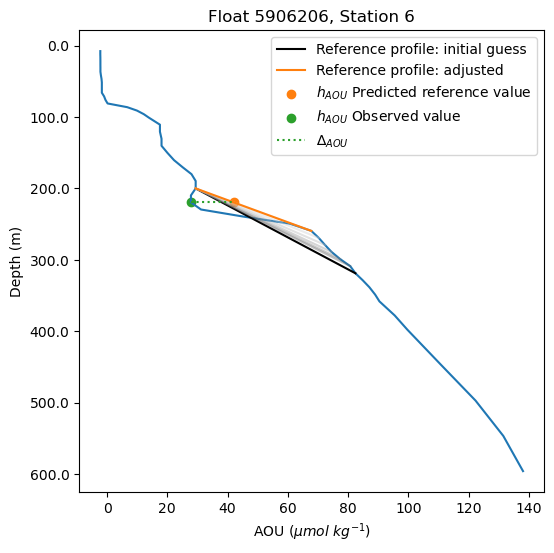

In [20]:
# Derive variables using TEOS-10 and the gsw package in python
fig = plt.figure(figsize=(6,6));
MLD_method = 'dens05'

for floatid in ['5906206']:
    print(floatid)
    db = xr.open_dataset('{}/{}QC.nc'.format(floatspath,floatid))
    
    # Assign Depth as a coordinate, which will allow integration by depth
    db = db.set_coords('Depth')
    
    # Assign relevant parameters to variables
    S = db.Salinity.copy(deep=True)
    T = db.Temperature.copy(deep=True)
    P = db.Pressure.copy(deep=True)
    Z = db.Depth.copy(deep=True)
    depths = Z.copy(deep=True)
    dens = db.Sigma_theta.copy(deep=True)
    dens_QFA = db.Sigma_theta_QFA.copy(deep=True)
    lon2d = np.repeat(db.Lon.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS)) #reshape lon and lat into 2d arrays to input to absolute salinity function
    lat2d = np.repeat(db.Lat.values, len(db.N_LEVELS)).reshape(-1, len(db.N_LEVELS))
    
    # Check that all profiles have the same dimensions
    assert(np.shape(S) == np.shape(T) == np.shape(P) == np.shape(Z) == np.shape(dens))
    
    # Derive variables using TEOS-10 and the GSW package
    # AOU calculated using oxygen solubility from Garcia and Gordon (1992)
    # Spice calculated according to McDougall and Krzysik (2015)
    # MLDs calculated according to Carvalho et al (2017)
   
    absal = gsw.SA_from_SP(S, P, lon2d, lat2d)
    ctemp = gsw.CT_from_t(absal,T,P)
    ptemp = gsw.pt_from_t(absal,T,P,p_ref=0)
    spice = gsw.spiciness0(absal,ctemp) # Ref pressure 0db: "Calculates spiciness from Absolute Salinity and Conservative Temperature at a pressure of 0 dbar, as described by McDougall and Krzysik (2015)."
    o2sol = gsw.O2sol(absal,ctemp,P,lon2d,lat2d) # "solubility coefficients derived from the data of Benson and Krause (1984), as fitted by Garcia and Gordon (1992, 1993)."
    aou = o2sol - db.Oxygen.data # AOU = expected - observed
    
    # Add as data variables to the dataframe
    db["Spice"] = (['N_PROF', 'N_LEVELS'], spice.data)
    db["Absolute_Salinity"] = (['N_PROF', 'N_LEVELS'], absal.data)
    db["AOU"] = (['N_PROF', 'N_LEVELS'], aou.data)
    db["Conservative_Temp"] = (['N_PROF', 'N_LEVELS'], ctemp.data)
    db["Potential_Temp"] = (['N_PROF', 'N_LEVELS'], ptemp.data)
    
    if floatid in navis_floats:
        ######### DOWNSAMPLE NAVIS FLOATS
        #### Define the N_LEVELS depth indices across the float dataset that correspond to APEX sampling depths 
        #### Store indices in matrix downsampled_i
        #### Mark indices where there is no matchup in downsampled_i_fornan; downsampled data here will be marked nan
        #### N = N_PROF
        #### M = N_LEVELS
        downsampled_i = [] # NxM matrix of N_LEVELS indices for each profile at APEX depths
        downsampled_i_fornan = [ [] for _ in range(len(db.N_PROF))] # Nx0 matrix to hold indices where the Navis float did not sample at the given APEX depth
        
        for i in range(len(apex_schedule)): # For each APEX sampling depth
            d = apex_schedule[i] 
            
            diff_array = np.absolute(db.Depth-d) # NxM Difference array of the full depth dataset vs the target APEX depth
            diff_indices = diff_array.argmin(axis=1) #Nx1 the indices of the nearest depth in each profile (minimum difference)
            
            nearest_depths = db.Depth[:,diff_indices] # Nx1 retrieve the observed depths at those indices in each profile
            nearest_depths_diffs = np.absolute(nearest_depths-d) # Nx1 difference array of those indices versus the target depth (d)
            
            if d<=100:
                no_meas = np.where(nearest_depths_diffs>2.5)[0] # N_PROF Indices where the closest sampled depth was >2.5 m away from target depth (>halfway between 5 m sampling interval)
            elif d>100 and d<=360:
                no_meas = np.where(nearest_depths_diffs>5)[0] # N_PROF Indices where the closest sampled depth was >5 m away from target depth (>halfway between 10 m sampling interval)
            elif d>360 and d<=400:
                no_meas = np.where(nearest_depths_diffs>10)[0] # N_PROF Indices where the closest sampled depth was >10 m away from target depth (>halfway between 20 m sampling interval)
            elif d>400 and d<=1000:
                no_meas = np.where(nearest_depths_diffs>25)[0] # N_PROF Indices where the closest sampled depth was >25 m away from target depth (>halfway between 50 m sampling interval)
            
            for nprof in no_meas:
                downsampled_i_fornan[nprof].extend([59-i]) # Record the N_LEVEL indices for this N_PROF that are NaN
            
            downsampled_i.append(list(diff_indices.values))
            
            
        downsampled_i = np.flip(np.transpose(downsampled_i),axis=1) #  Transpose the matrix from MxN and shallow->deep, into NxM and deep->shallow (standard float data format)
    
        
        #########################
        ###### Use the downsample indices to downsample variable arrays
        
        if len(db.N_PROF)==1 and len(downsampled_i)==1:
            depths_ds = db.Depth[:,downsampled_i[0]]
            P_ds = db.Pressure[:,downsampled_i[0]]
            dens_ds = db.Sigma_theta[:,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[:,downsampled_i[0]]
            T_ds = db.Conservative_Temp[:,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[:,downsampled_i[0]]
            spice_ds = db.Spice[:,downsampled_i[0]]
            aou_ds = db.AOU[:,downsampled_i[0]]
            chl_ds = db.Chl_a[:,downsampled_i[0]]
            bbp_ds = db.b_bp700[:,downsampled_i[0]]
            poc_ds = db.POC[:,downsampled_i[0]]
            
        elif len(db.N_PROF) > 1:
            # Initialize downsampled arrays for each variable by indexing the first profile at just the APEX depths
            depths_ds = db.Depth[0,downsampled_i[0]]
            P_ds = db.Pressure[0,downsampled_i[0]]
            dens_ds = db.Sigma_theta[0,downsampled_i[0]]
            dens_QFA_ds = db.Sigma_theta_QFA[0,downsampled_i[0]]
            T_ds = db.Conservative_Temp[0,downsampled_i[0]]
            S_ds = db.Absolute_Salinity[0,downsampled_i[0]]
            spice_ds = db.Spice[0,downsampled_i[0]]
            aou_ds = db.AOU[0,downsampled_i[0]]
            chl_ds = db.Chl_a[0,downsampled_i[0]]
            bbp_ds = db.b_bp700[0,downsampled_i[0]]
            poc_ds = db.POC[0,downsampled_i[0]]
            
            # Replace unsampled depths with NAN (at the N_LEVELS indices recorded earlier)
            depths_ds[downsampled_i_fornan[0]] = np.nan
            P_ds[downsampled_i_fornan[0]] = np.nan
            dens_ds[downsampled_i_fornan[0]] = np.nan
            dens_QFA_ds[downsampled_i_fornan[0]] = np.nan
            T_ds[downsampled_i_fornan[0]] = np.nan
            S_ds[downsampled_i_fornan[0]] = np.nan
            spice_ds[downsampled_i_fornan[0]] = np.nan
            aou_ds[downsampled_i_fornan[0]] = np.nan
            chl_ds[downsampled_i_fornan[0]] = np.nan
            bbp_ds[downsampled_i_fornan[0]] = np.nan
            poc_ds[downsampled_i_fornan[0]] = np.nan
            
            # Downsample each variable by indexing each profile, substituting NANs, and then concatenating with the downsampled data array
            for i in range(1,len(downsampled_i)):
                depths_ds_prof = db.Depth[i,downsampled_i[i]]
                P_ds_prof = db.Pressure[i,downsampled_i[i]]
                dens_ds_prof = db.Sigma_theta[i,downsampled_i[i]]
                dens_QFA_ds_prof = db.Sigma_theta_QFA[i,downsampled_i[i]]
                T_ds_prof = db.Conservative_Temp[i,downsampled_i[i]]
                S_ds_prof = db.Absolute_Salinity[i,downsampled_i[i]]
                spice_ds_prof = db.Spice[i,downsampled_i[i]]
                aou_ds_prof = db.AOU[i,downsampled_i[i]]
                chl_ds_prof = db.Chl_a[i,downsampled_i[i]]
                bbp_ds_prof = db.b_bp700[i,downsampled_i[i]]
                poc_ds_prof = db.POC[i,downsampled_i[i]]
                    
                depths_ds_prof[downsampled_i_fornan[i]] = np.nan
                P_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_ds_prof[downsampled_i_fornan[i]] = np.nan
                dens_QFA_ds_prof[downsampled_i_fornan[i]] = np.nan
                T_ds_prof[downsampled_i_fornan[i]] = np.nan
                S_ds_prof[downsampled_i_fornan[i]] = np.nan
                spice_ds_prof[downsampled_i_fornan[i]] = np.nan
                aou_ds_prof[downsampled_i_fornan[i]] = np.nan
                chl_ds_prof[downsampled_i_fornan[i]] = np.nan
                bbp_ds_prof[downsampled_i_fornan[i]] = np.nan
                poc_ds_prof[downsampled_i_fornan[i]] = np.nan
                    
                depths_ds = xr.concat([depths_ds, depths_ds_prof], dim="N_PROF")
                P_ds = xr.concat([P_ds, P_ds_prof], dim="N_PROF")
                dens_ds = xr.concat([dens_ds, dens_ds_prof], dim="N_PROF")
                dens_QFA_ds = xr.concat([dens_QFA_ds, dens_QFA_ds_prof], dim="N_PROF")
                T_ds = xr.concat([T_ds, T_ds_prof], dim="N_PROF")
                S_ds = xr.concat([S_ds, S_ds_prof], dim="N_PROF")
                spice_ds = xr.concat([spice_ds, spice_ds_prof], dim="N_PROF")
                aou_ds = xr.concat([aou_ds, aou_ds_prof], dim="N_PROF")
                chl_ds = xr.concat([chl_ds, chl_ds_prof], dim="N_PROF")
                bbp_ds = xr.concat([bbp_ds, bbp_ds_prof], dim="N_PROF")
                poc_ds = xr.concat([poc_ds, poc_ds_prof], dim="N_PROF")
        
        depths = depths_ds.copy(deep=True) # For code reuseability with APEX floats, now with the truncated shape of the downsampled arrays
        dens = dens_ds.copy(deep=True)
    #########################
    #########################
    
    if MLD_method == 'maxn2':
        if floatid in apex_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    elif MLD_method == 'dens05':
        if floatid in apex_floats:
            MLD, indicesMLD = mld05(dens,dens_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens, P, Z, absal, ctemp, num_rows_ignore=0)
        elif floatid in navis_floats:
            MLD, indicesMLD = mld05(dens_ds,dens_QFA_ds)
            MLD_navis, indicesMLD_navis = mld05(db.Sigma_theta,db.Sigma_theta_QFA)
            MLD_maxn2, indicesMLD_maxn2, maxn2 = profile2mld_n2(dens_ds, P_ds, depths_ds, S_ds, T_ds, num_rows_ignore=0)
    
    # Add as data variables to the dataframe
    db["Mixed_Layer_Depth"] = (['N_PROF'], MLD)
    db['Max_N2'] = ('N_PROF',maxn2)
    
    #########################
    # Calculate 3-bin rolling medians for variables of interest. Don't drop nans.
    # For Navis floats, use the downsampled data
    
    if floatid in apex_floats:
        
        T_bin3 = db.Conservative_Temp.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = db.Absolute_Salinity.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = db.Spice.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = db.AOU.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin20 = db.AOU.rolling(N_LEVELS=20,center=True,min_periods=10).median()
        bbp_bin3 = db.b_bp700.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = db.Chl_a.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = db.POC.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        
        bbp_despiked = np.nan
        bbp_spikes = np.nan
        chl_despiked = np.nan
        chl_spikes = np.nan
        poc_despiked = np.nan
        poc_spikes = np.nan
    
    elif floatid in navis_floats: # Use the downsampled data for rolling medians for Navis data
        
        T_bin3 = T_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        S_bin3 = S_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        spicebin3 = spice_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin3 = aou_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        aou_bin20 = aou_ds.rolling(N_LEVELS=20,center=True,min_periods=10).median()
        bbp_bin3 = bbp_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        chl_bin3 = chl_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()
        poc_bin3 = poc_ds.rolling(N_LEVELS=3,center=True,min_periods=2).median()

    # Calculate the chl/bbp ratio by dividing the 3-bin smoothed profiles
    chl_bbp_ratio3 = chl_bin3/bbp_bin3
    
    ########### Create empty variables for reference profiles of variables of interest. Use these just to input the points used to calculate the reference profile (above and below an anomaly).
    ####### By integrating through these points (straight line), I will calculate the "background" integrated quantity of a given variable
    # First duplicate the original arrays
    bbp_refprofs = bbp_bin3.copy(deep=True) 
    chl_refprofs = chl_bin3.copy(deep=True)
    poc_refprofs = poc_bin3.copy(deep=True)
    chl_bbp_refprofs = chl_bbp_ratio3.copy(deep=True)
    
    # Then make them all NaN
    bbp_refprofs[:,:], chl_refprofs[:,:], poc_refprofs[:,:], chl_bbp_refprofs[:,:] = np.nan,np.nan,np.nan,np.nan
    
    ###############
    
    
    for i in [5]: # For each profile:   
        
        prof_anoms = [] # Record the values of AOU anomalies in this vertical profile, as well as their depth indices [[magnitude,index]]
        
        if np.any(np.where(depths[i]<600)) and S[i].dropna(dim='N_LEVELS')[-1]<35 and -30>db.Lat[i]>-65 and ~np.isnan(db.Mixed_Layer_Depth[i]) and (floatid,i) not in itertools.chain(bad_t,bad_s,bad_oxygen): # If the profile reached a depth shallower than 600 m, and has a surface Salinity <35 (to discard tropical water incursions), is between -30 and -65 latitude, and had a valid MLD calculation (not faulty CTD)
            
            lons_all.append(db.Lon[i].item()) # Record the profile as considered (coordinates)
            lats_all.append(db.Lat[i].item())
            
            index600 = np.where(depths[i]<600)[0][0] # Get the first index of profie i where depth < 600 m (depth array = [deep:shallow])
            index1000 = np.where(depths[i]<1000)[0][0] # Get the first index of profie i where depth < 1000 m (depth array = [deep:shallow]) 
            
            if np.any(np.where(depths[i]>100)): # Get the last index where depth > 100 m
                index100 = np.where(depths[i]>100)[0][-1]
            else:
                index100 = np.nan
                
            upperbound = int(np.nanmin([index100,indicesMLD[i]])) # Stop either 100 m or the MLD, whichever comes first
            

            
            if index600 < indicesMLD[i]: # If the mixed layer is shallower than 600 m (otherwise ignore the profile)
                
                # Find local maxima in 3-bin smoothed profiles using scipy's find_peaks method: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
                aou_peaks = find_peaks(-aou_bin3[i])[0] # Returns the indices of the peaks. Negative input in order to detect minima
                spice_peaks = find_peaks(-spicebin3[i])[0]
                #poc_peaks = find_peaks(poc_bin3[i])[0] # Detect positive POC peaks
                
                if np.any(aou_peaks) and np.any(spice_peaks): # If there are peaks in both AOU and spice profiles
                    
                    # Check that there are peaks between index600 and upperbound+1
                    aou_peaks = aou_peaks[np.where((aou_peaks<upperbound) & (aou_peaks>index600))[0]] # Filter peak indices -- only those indices in the given depth range
                    spice_peaks = spice_peaks[np.where((spice_peaks<upperbound) & (spice_peaks>index600))[0]]
                    
                    if np.any(aou_peaks) and np.any(spice_peaks): # If both AOU and spice have peaks in the given depth range
                    
                        for x in aou_peaks: # Pairwise assessment of each AOU and spice peak pair
                            for y in spice_peaks: # Note: define AOU and spice at their *respective* peak depths (may be slightly offset). MAY REVISIT LATER?
                                
                                if (abs(aou_bin3[i].Depth[x] - spicebin3[i].Depth[y]) < 30): # The peaks must be be within 30 m of each other (for most floats, this is 3 sampling intervals)
                                    
                                    # Record the depths and values of the AOU and spice peaks
                                    aou_peakdepth = aou_bin3[i,x].Depth.item()
                                    spice_peakdepth = spicebin3[i,y].Depth.item()
                                    
                                    aou_peakval  = aou_bin3[i,x].item()
                                    spice_peakval = spicebin3[i,y].item()
                                    
                                    plt.plot(aou_bin3[i,index600:],np.negative(aou_bin3[i,index600:].Depth.values))
                                    #plt.plot(aou_bin20[i,index600:],np.negative(aou_bin20[i,index600:].Depth.values),linestyle='dotted')
                                    
                                    ####### Define the reference profiles (without subduction anomalies)
                                    
                                    ### 1) Start by identifying the points 100 m above and below each peak
                                    aou_reference_lower_i = np.where(depths[i]<aou_peakdepth+100)[0][0] # Index of the point 100 m below the AOU peak (less than/equal to)
                                    aou_reference_upper_i = np.where(depths[i]>aou_peakdepth-100)[0][-1] # Index of the point 100 m above the AOU peak (less than/equal to)
                                    
                                    spice_reference_lower_i = np.where(depths[i]<spice_peakdepth+100)[0][0] #  Index of the point 100 m below the spice peak (less than/equal to)
                                    spice_reference_upper_i = np.where(depths[i]>spice_peakdepth-100)[0][-1] ## Index of the point 100 m above the spice peak (less than/equal to)
                                    
                                    ### 2) For each depth interval (100 m above, 100m below), identify the maximum (most positive) AOU or spice value
                                    aou_upperbound_maxval = aou_bin3[i, x:aou_reference_upper_i+1].max() # Value of the maximum AOU value in the (peak+100m) depth range (may have duplicates)
                                    aou_upperbound_max_i = np.where(aou_bin3[i, x:aou_reference_upper_i+1]==aou_upperbound_maxval)[0][0] # Find the first index in this range (deepest depth) where this maximum value occurs
                                    aou_upperbound_max = aou_bin3[i, x:aou_reference_upper_i+1][aou_upperbound_max_i].item() # The maximum value and its depth
                                    aou_upperbound_max_depth = aou_bin3[i, x:aou_reference_upper_i+1][aou_upperbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    aou_lowerbound_maxval = aou_bin3[i,aou_reference_lower_i:x].max() # Value of the maximum AOU value in the (peak+100m) depth range (may have duplicates)
                                    aou_lowerbound_max_i = np.where(aou_bin3[i,aou_reference_lower_i:x]==aou_lowerbound_maxval)[0][-1] # Find the last index in this range (shallowest depth) where this maximum value occurs
                                    aou_lowerbound_max = aou_bin3[i,aou_reference_lower_i:x][aou_lowerbound_max_i].item() # The maximum value and its depth
                                    aou_lowerbound_max_depth = aou_bin3[i,aou_reference_lower_i:x][aou_lowerbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    spice_upperbound_maxval = spicebin3[i, y:spice_reference_upper_i+1].max() # Value of the maximum spice value in the (peak+100m) depth range (may have duplicates)
                                    spice_upperbound_max_i = np.where(spicebin3[i, y:spice_reference_upper_i+1]==spice_upperbound_maxval)[0][0] # Find the first index in this range (deepest depth) where this maximum value occurs
                                    spice_upperbound_max = spicebin3[i, y:spice_reference_upper_i+1][spice_upperbound_max_i].item() # The maximum value and its depth
                                    spice_upperbound_max_depth = spicebin3[i, y:spice_reference_upper_i+1][spice_upperbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    spice_lowerbound_maxval = spicebin3[i,spice_reference_lower_i:y].max() # Value of the maximum spice value in the (peak+100m) depth range (may have duplicates)
                                    spice_lowerbound_max_i = np.where(spicebin3[i,spice_reference_lower_i:y]==spice_lowerbound_maxval)[0][-1] # Find the last index in this range (shallowest depth) where this maximum value occurs
                                    spice_lowerbound_max = spicebin3[i,spice_reference_lower_i:y][spice_lowerbound_max_i].item() # The maximum value and its depth
                                    spice_lowerbound_max_depth = spicebin3[i,spice_reference_lower_i:y][spice_lowerbound_max_i].Depth.item() # The maximum value and its depth
                                    
                                    ### 3) Construct the reference profile: draw a straight line between the maximum values above and below the peak
                                    aou_reference_x = np.array([aou_upperbound_max_depth, aou_lowerbound_max_depth]).reshape((-1, 1)) # Independent variable: depth
                                    aou_reference_y = np.array([aou_upperbound_max, aou_lowerbound_max]) # Dependent variable: predicted AOU value
                                    
                                    aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y) # Construct the regression model 
                                    
                                    spice_reference_x = np.array([spice_upperbound_max_depth, spice_lowerbound_max_depth]).reshape((-1, 1)) # Independent variable: depth
                                    spice_reference_y = np.array([spice_upperbound_max, spice_lowerbound_max]) # Dependent variable: predicted spice value
                                    
                                    spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y) # Construct the regression model 
                                    

                                    ### 3b) Iteratively adjust the reference profile so that it doesn't intersect the observed profile
                                    # Construct the reference profile at all depths
                                    aou_refprof_iter_lower_i = np.where(aou_bin3[i].Depth==aou_lowerbound_max_depth)[0][0]
                                    aou_refprof_iter_upper_i = np.where(aou_bin3[i].Depth==aou_upperbound_max_depth)[0][0]
                                    aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                    aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                    aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                    aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                
                                    aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                    aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                    
                                    plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),c='black',label='Reference profile: initial guess')
                                    
                                    opt_iter = 3
                                    colors = plt.cm.Greys_r(np.linspace(0,1,11))
                                    
                                    if np.any(aou_refprof_iter_diff[0:aou_refprof_iter_peakindex] < -1e-13): # If the bottom of the observed profile goes above (more + than) the reference profile
                                        intersectLower = True
                                        
                                        while (aou_refprof_iter_lower_i < x-1) and intersectLower==True: 
                                            if np.isnan(aou_bin3[i,aou_refprof_iter_lower_i+1]): #If the next index is an nan, stop the optimization routine
                                                break
                                            #print(aou_refprof_iter_diff)
                                            aou_refprof_iter_lower_i +=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                            aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                            aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                            aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            # Reconstruct the regression reference model
                                            aou_reference_x = np.array([aou_refprof_iter_depths[-1], aou_refprof_iter_depths[0]]).reshape((-1, 1))
                                            aou_reference_y = np.array([aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0]])
                                            aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                            aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                            
                                            if np.any(aou_refprof_iter_diff[0:aou_refprof_iter_peakindex] < -1e-13) == False:
                                                intersectLower = False
                                            plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),c=colors[opt_iter],alpha=0.4)
                                            opt_iter+=1
                                        
                                    if np.any(aou_refprof_iter_diff[aou_refprof_iter_peakindex:] < -1e-13): # If the top of the observed profile goes above (more + than) the reference profile
                                        intersectUpper = True
                                        
                                        while (aou_refprof_iter_upper_i > x+1) and intersectUpper==True:
                                            if np.isnan(aou_bin3[i,aou_refprof_iter_upper_i-1]):
                                                break
                                                
                                            aou_refprof_iter_upper_i -=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            aou_refprof_iter_depths = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].Depth.values
                                            aou_refprof_iter_depths_input = aou_refprof_iter_depths.reshape((-1,1))
                                            aou_refprof_iter_observed = aou_bin3[i,aou_refprof_iter_lower_i:aou_refprof_iter_upper_i+1].values
                                            aou_refprof_iter_peakindex = np.where(aou_refprof_iter_depths==aou_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            # Reconstruct the regression reference model
                                            aou_reference_x = np.array([aou_refprof_iter_depths[-1], aou_refprof_iter_depths[0]]).reshape((-1, 1))
                                            aou_reference_y = np.array([aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0]])
                                            aou_model = LinearRegression().fit(aou_reference_x, aou_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            aou_refprof_iter_vals = aou_model.predict(aou_refprof_iter_depths_input)
                                            aou_refprof_iter_diff = aou_refprof_iter_vals - aou_refprof_iter_observed
                                            
                                            if np.any(aou_refprof_iter_diff[aou_refprof_iter_peakindex:] < -1e-13) == False:
                                                intersectUpper = False
                                        plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),alpha=0.5)
                                    
                                    plt.plot(aou_refprof_iter_vals,np.negative(aou_refprof_iter_depths),c='tab:Orange',label='Reference profile: adjusted')    
                                    ### 3c) Repeat for spice profile. Iteratively adjust the reference profile so that it doesn't intersect the observed profile
                                    # Construct the reference profile at all depths
                                    spice_refprof_iter_lower_i = np.where(spicebin3[i].Depth==spice_lowerbound_max_depth)[0][0]
                                    spice_refprof_iter_upper_i = np.where(spicebin3[i].Depth==spice_upperbound_max_depth)[0][0]
                                    spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                    spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                    spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                    spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                    
                                    spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                    spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                    
                                    if np.any(spice_refprof_iter_diff[0:spice_refprof_iter_peakindex] < 0): # If the bottom of the observed profile goes above (more + than) the reference profile
                                        intersectLower = True
                                        
                                        while (spice_refprof_iter_lower_i < y-1) and intersectLower==True:
                                            if np.isnan(spicebin3[i,spice_refprof_iter_lower_i+1]):
                                                break
                                                
                                            spice_refprof_iter_lower_i +=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                            spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                            spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                            spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                            
                                            spice_reference_x = np.array([spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0]]).reshape((-1, 1))
                                            spice_reference_y = np.array([spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0]])
                                            spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                            spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                            
                                            if np.any(spice_refprof_iter_diff[0:spice_refprof_iter_peakindex] < 0) == False:
                                                intersectLower = False
                                    
                                    if np.any(spice_refprof_iter_diff[spice_refprof_iter_peakindex:] < 0): # If the top of the observed profile goes above (more + than) the reference profile
                                        intersectUpper = True
                                        
                                        while (spice_refprof_iter_upper_i > y+1) and intersectUpper==True:
                                            if np.isnan(spicebin3[i,spice_refprof_iter_upper_i-1]):
                                                break
                                                
                                            spice_refprof_iter_upper_i -=1 # Iterate the lowerbound one index shallower at a time
                                            
                                            spice_refprof_iter_depths = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].Depth.values
                                            spice_refprof_iter_depths_input = spice_refprof_iter_depths.reshape((-1,1))
                                            spice_refprof_iter_observed = spicebin3[i,spice_refprof_iter_lower_i:spice_refprof_iter_upper_i+1].values
                                            spice_refprof_iter_peakindex = np.where(spice_refprof_iter_depths==spice_peakdepth)[0][0] # The index within the reference profile of the peak
                                                
                                            spice_reference_x = np.array([spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0]]).reshape((-1, 1))
                                            spice_reference_y = np.array([spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0]])
                                            spice_model = LinearRegression().fit(spice_reference_x, spice_reference_y)
                                            
                                            # Use the model to predict the reference profile again
                                            spice_refprof_iter_vals = spice_model.predict(spice_refprof_iter_depths_input)
                                            spice_refprof_iter_diff = spice_refprof_iter_vals - spice_refprof_iter_observed
                                            
                                            if np.any(spice_refprof_iter_diff[spice_refprof_iter_peakindex:] < 0) == False:
                                                intersectUpper = False
                                    
                                    
                                
                                    ### 4) Determine the anomaly size at the peak
                                    aou_refval = aou_model.predict([[aou_peakdepth]]).item()
                                    spice_refval = spice_model.predict([[spice_peakdepth]]).item()
                                    
                                    ######## Determine if it's a true anomaly. Must meet 4 conditions to be an anomaly
                                    # Depth of the AOU and spice peaks must be within 30 m of each other (for most floats, this is 3 sampling intervals)
                                    # The AOU anomaly (diff between 3-bin and 20-bin medians) must be < -8
                                    # The spice anomaly (diff between 3-bin and 20-bin medians) must be < -0.05
                                    # Must be at least 100 m below the MLD
                                    
                                    if np.less(aou_peakval - aou_refval, -8) and np.less(spice_peakval - spice_refval, -0.05) and aou_peakdepth > (MLD[i]+100):
                                        # Record this profile's anomalies: [AOU N_LEVELs index, AOU magnitude, spice N_LEVELS index, spice magnitude, AOU reference values (upper/lower), spice reference values (upper/lower), predicted AOU reference, predicted spice reference]
                                        #prof_anoms.append([x, aou_peakval - aou_refval, y, spice_peakval - spice_refval, aou_reference_x.reshape(1,-1)[0], aou_reference_y, spice_reference_x.reshape(1,-1)[0], spice_reference_y, aou_refval, spice_refval]) 
                                        prof_anoms.append([x, aou_peakval, aou_peakval - aou_refval, y, spice_peakval, spice_peakval - spice_refval, aou_refprof_iter_depths[-1], aou_refprof_iter_upper_i, aou_refprof_iter_depths[0], aou_refprof_iter_lower_i, aou_refprof_iter_observed[-1], aou_refprof_iter_observed[0], spice_refprof_iter_depths[-1], spice_refprof_iter_depths[0], spice_refprof_iter_observed[-1], spice_refprof_iter_observed[0], aou_refval, spice_refval]) 
                                        plt.scatter(aou_refval,-aou_peakdepth,c='tab:Orange',label='$h_{AOU}$ Predicted reference value')
                                        plt.scatter(aou_peakval,-aou_peakdepth,c='tab:Green',label='$h_{AOU}$ Observed value')
                                        
                                        
ax=plt.gca()                                        

plt.ylabel('Depth (m)')
@mticker.FuncFormatter
def major_formatter(x, pos):
    label = str(-x) if x < 0 else str(x)
    return label
ax=plt.gca()
plt.plot([aou_peakval,aou_refval],[-aou_peakdepth,-aou_peakdepth],c='tab:Green',linestyle='dotted',label='$∆_{AOU}$')

ax.yaxis.set_major_formatter(major_formatter)
plt.xlabel('AOU ($µmol$ $kg^{-1}$)')
plt.title('Float 5906206, Station 6')
#plt.ylim(-400,0)
plt.legend()